In [58]:
# Importações
import pandas as pd
import numpy as np
import requests as rq
import zipfile
import datetime
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Atribuições iniciais

# URL do arquivo zip que você deseja baixar
url = 'https://portaldatransparencia.gov.br/download-de-dados/emendas-parlamentares/UNICO'

headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
            'Referer': f"{url}"
}

pd.set_option('display.float_format', lambda x: '%.2f' % x)

data = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

name_directory = f"Emenda_Parlamentar_{data.split(' ')[0].replace('-','')}"

if not os.path.exists(name_directory):
    os.makedirs(name_directory)

response = rq.get(url, headers=headers)

In [60]:
# Extraindo arquivos do zip e inserindo no diretório desejado
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(path=name_directory)

In [61]:
# Lendo arquivo CSV usando pd.read_csv
df_csv = pd.read_csv(f'{name_directory}/Emendas.csv', sep=';', encoding='ISO-8859-1')

In [62]:
# Ajustando os tipos das colunas e seus valores
df_csv['Ano da Emenda'] = df_csv['Ano da Emenda'].astype(int)
df_csv['Nome do Autor da Emenda'] = df_csv['Nome do Autor da Emenda'].str.title()
df_csv['Valor Empenhado'] = df_csv['Valor Empenhado'].str.replace(',', '.').astype(float)
df_csv['Valor Liquidado'] = df_csv['Valor Liquidado'].str.replace(',', '.').astype(float)
df_csv['Valor Pago'] = df_csv['Valor Pago'].str.replace(',', '.').astype(float)
df_csv['Valor Restos A Pagar Inscritos'] = df_csv['Valor Restos A Pagar Inscritos'].str.replace(',', '.').astype(float)
df_csv['Valor Restos A Pagar Cancelados'] = df_csv['Valor Restos A Pagar Cancelados'].str.replace(',', '.').astype(float)
df_csv['Valor Restos A Pagar Pagos'] = df_csv['Valor Restos A Pagar Pagos'].str.replace(',', '.').astype(float)

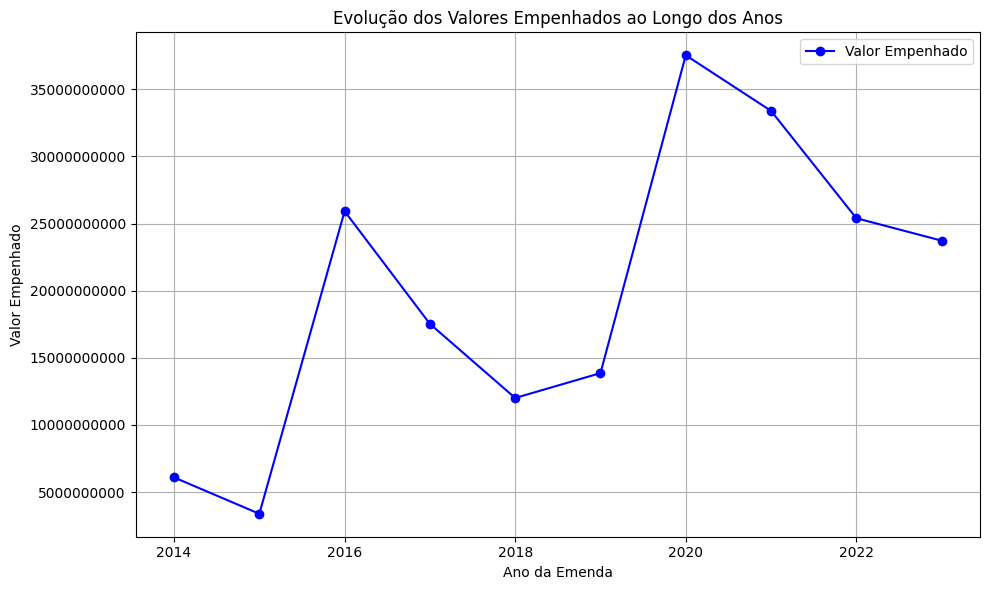

In [63]:
# Evolução anual dos valores empenhados (âmbito geral)
valor_empenhado_agrupado = df_csv.groupby('Ano da Emenda')['Valor Empenhado'].sum()
df_evolucao_empenhados = pd.DataFrame({'Ano da Emenda': valor_empenhado_agrupado.index, 'Valor Empenhado': valor_empenhado_agrupado.values})
#print(df_evolucao_empenhados)

# CRIANDO O GRÁFICO
# Definindo o tamanho do gráfico
plt.figure(figsize=(10, 6))

# Plotando os dados, usando coluna Ano da Emenda e Valor Empenhado
plt.plot(df_evolucao_empenhados['Ano da Emenda'], df_evolucao_empenhados['Valor Empenhado'], marker='o', color='b', label='Valor Empenhado')

# Adiciona rótulos aos eixos e um título ao gráfico
plt.xlabel('Ano da Emenda')
plt.ylabel('Valor Empenhado')
plt.title('Evolução dos Valores Empenhados ao Longo dos Anos')

# Adiciona uma legenda ao gráfico
plt.legend()

# Adiciona uma grade ao gráfico (opcional)
plt.grid(True)

plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig(f"{name_directory}/Evolucao_Empenhados_Anual.png")
plt.show()

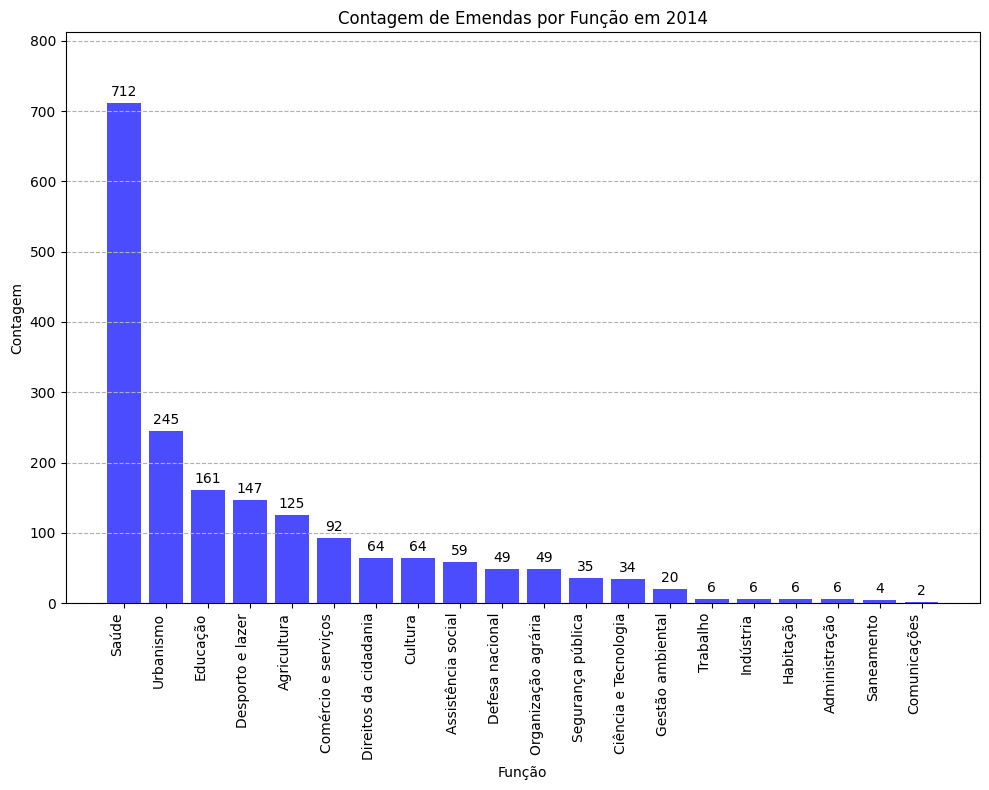

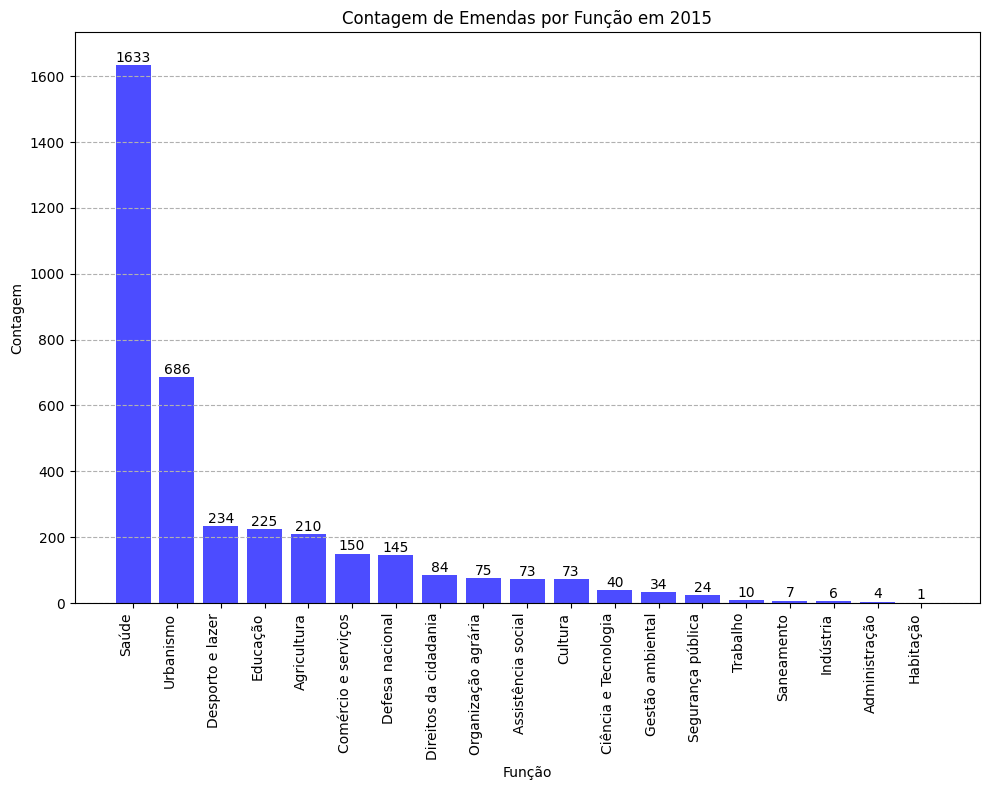

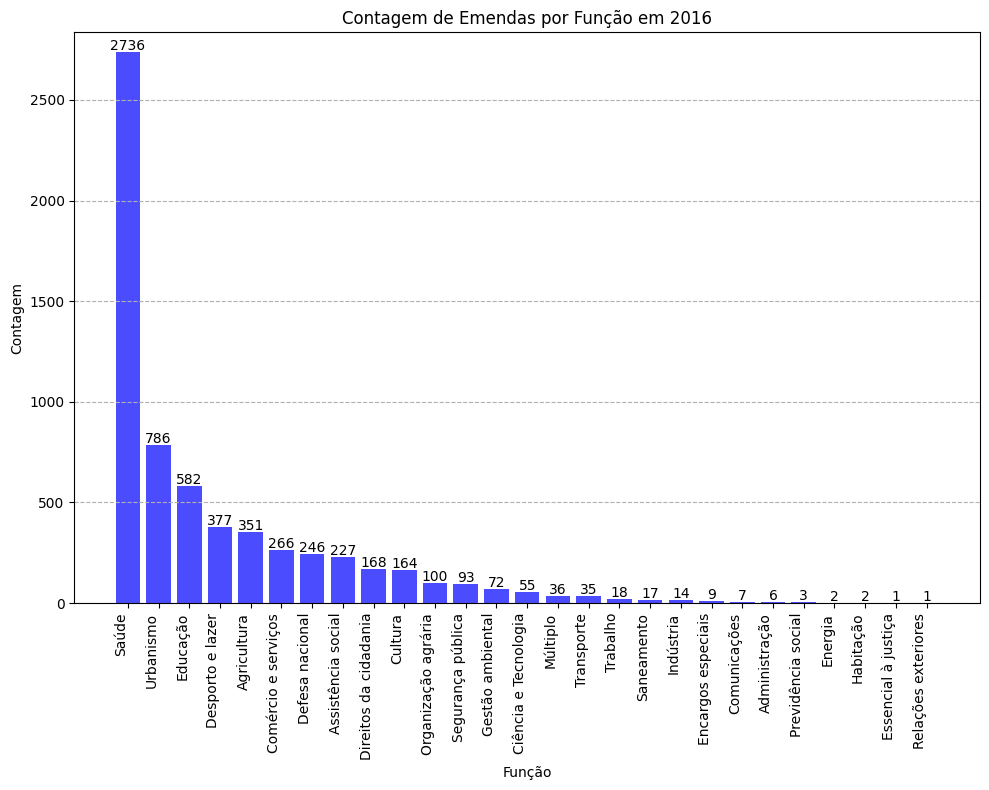

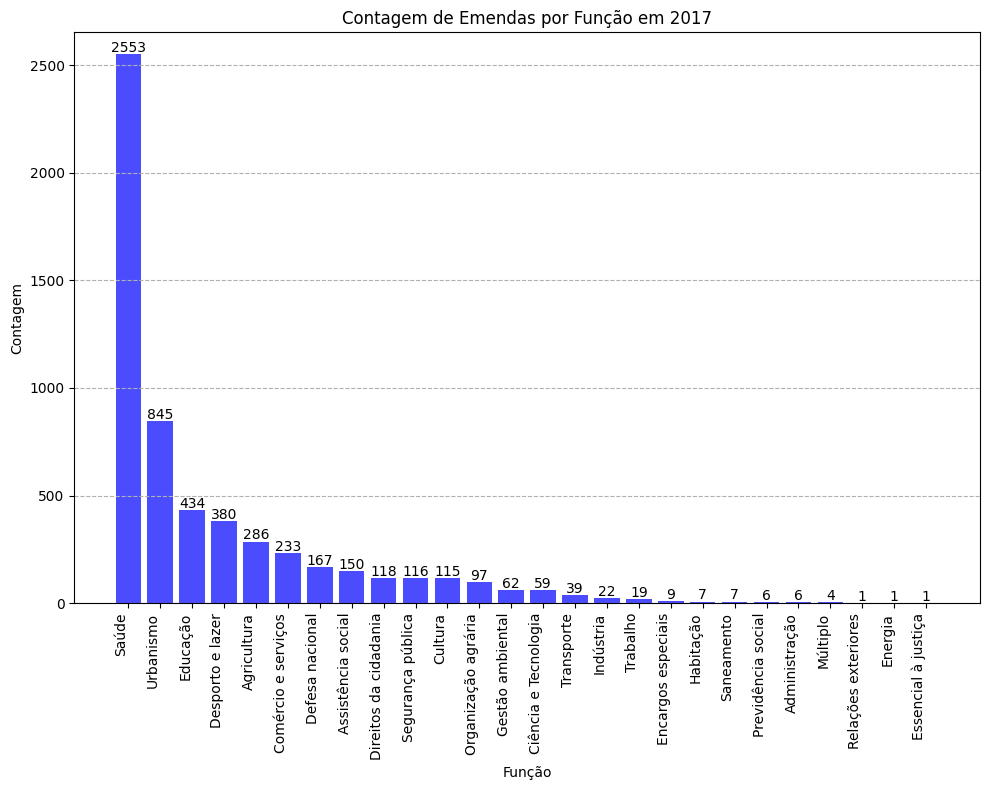

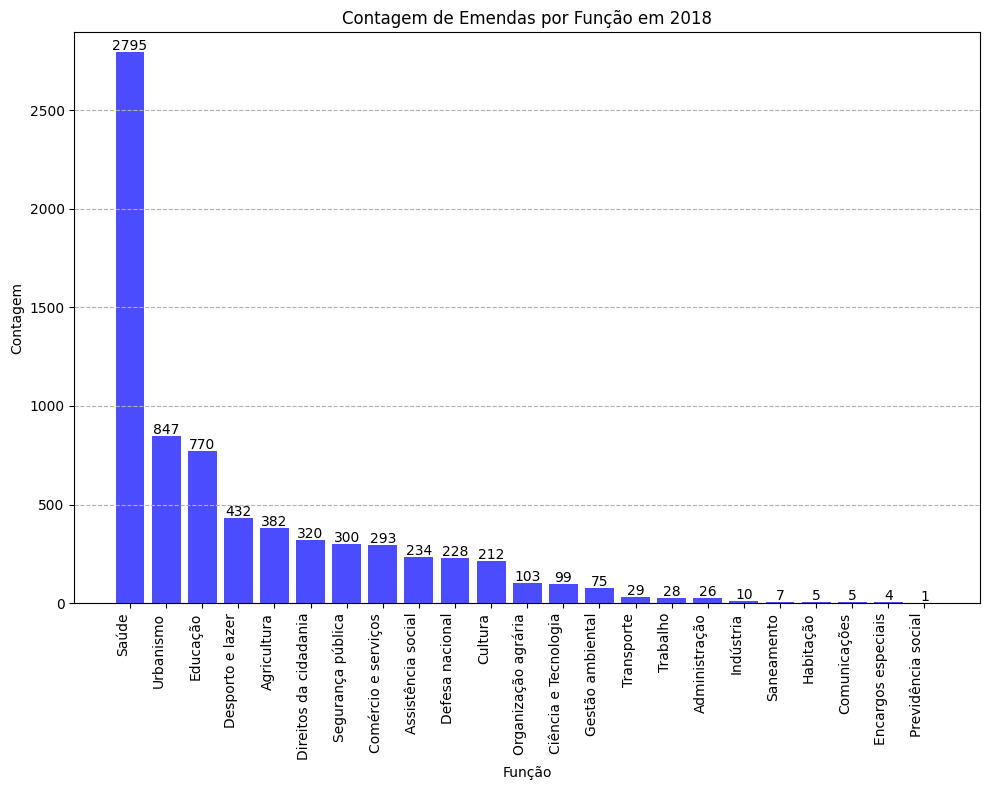

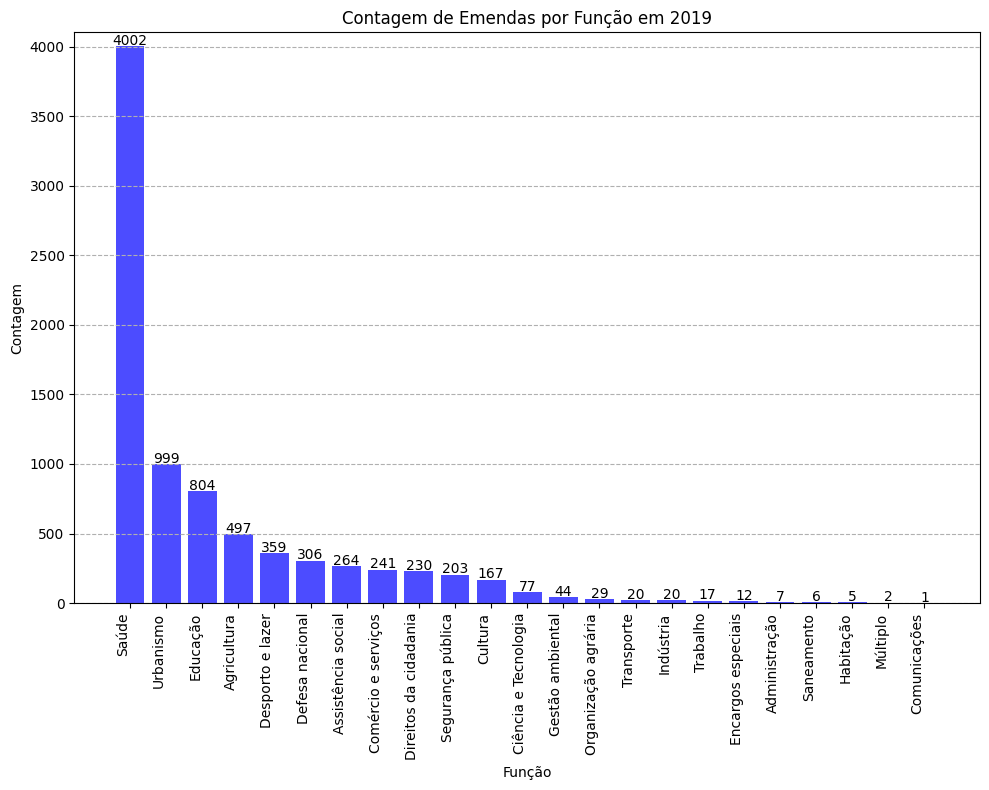

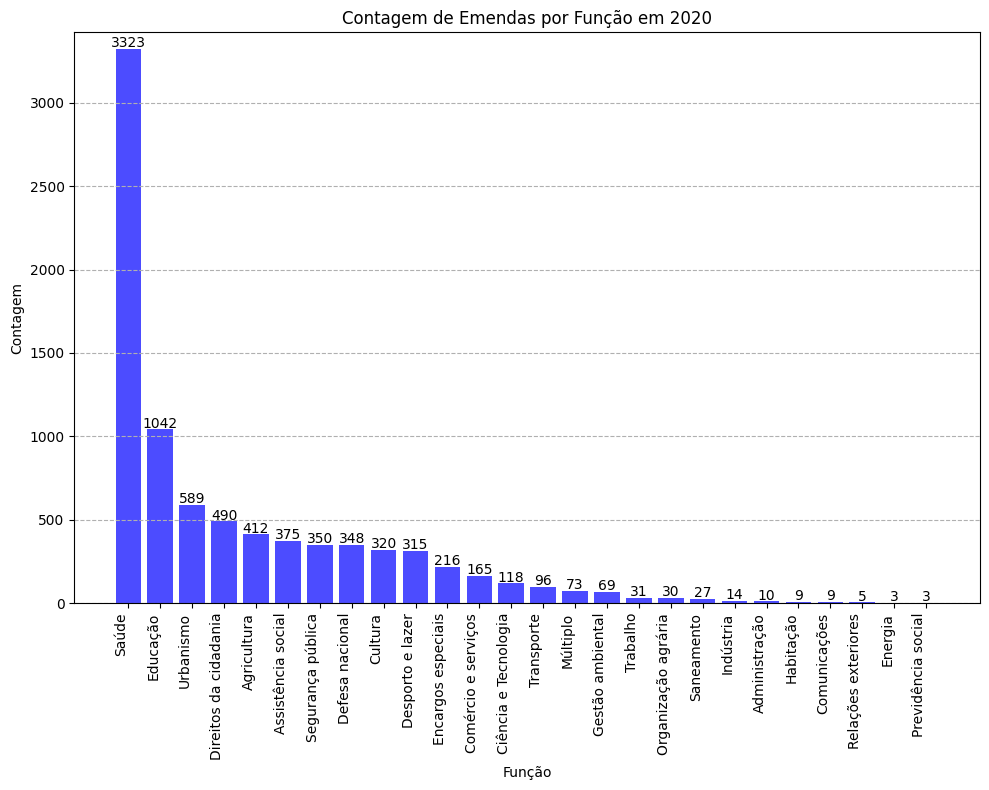

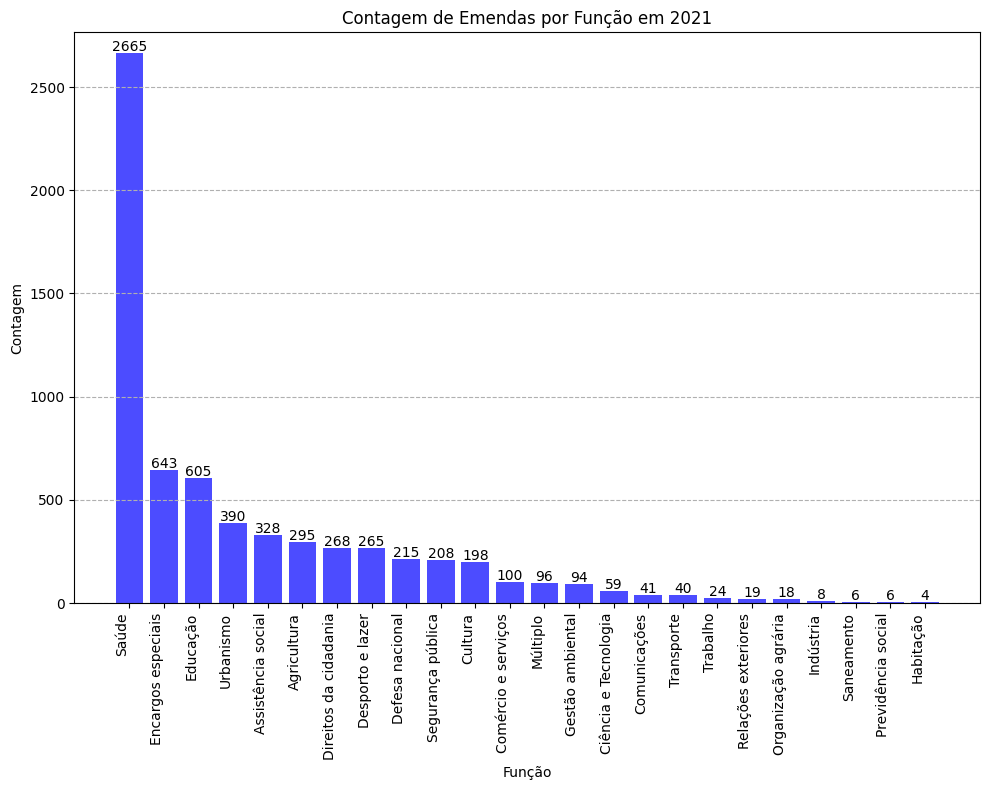

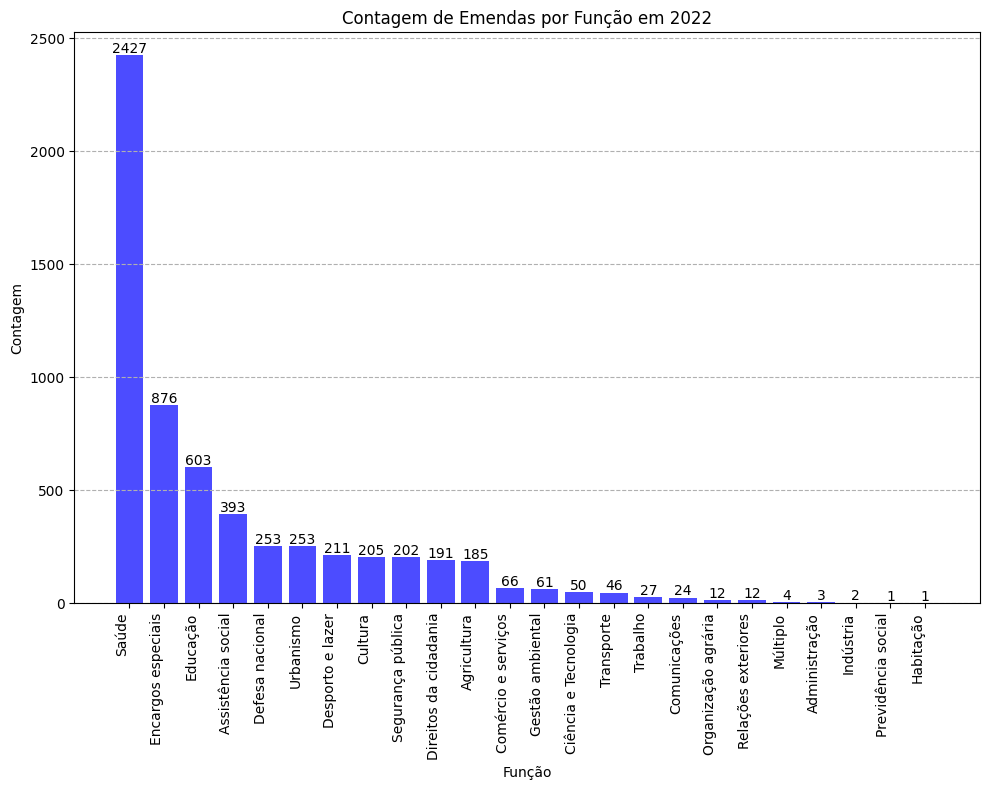

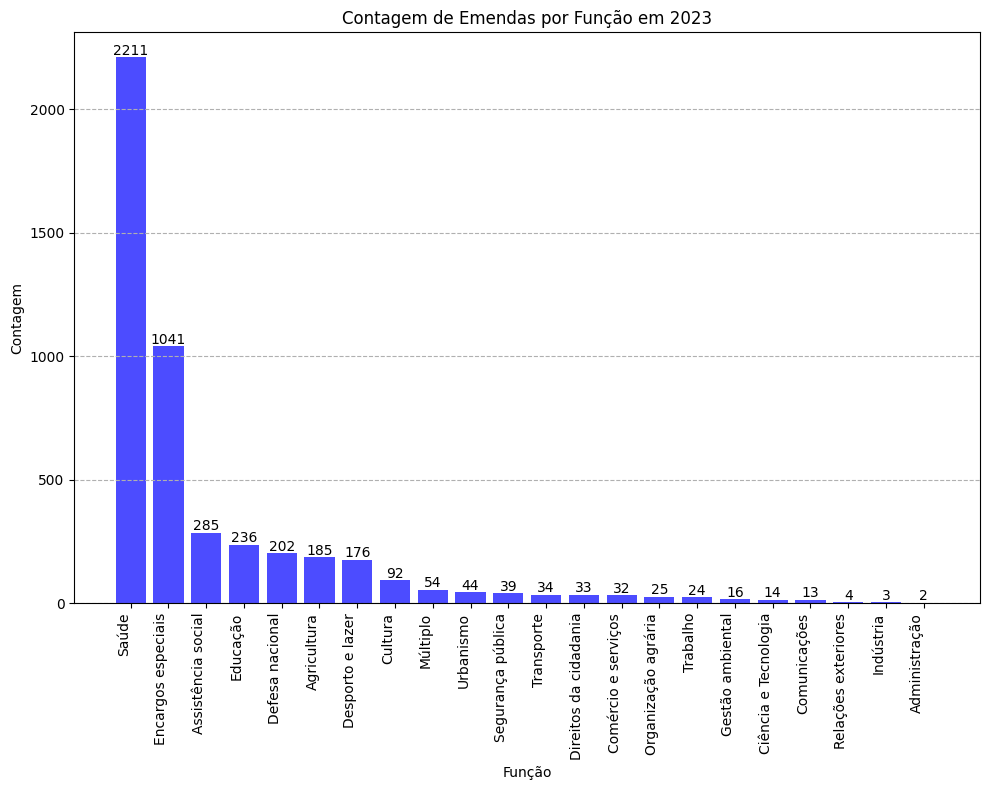

In [64]:
# Ordenação dos setores mais "amparados"
resultados_anual = df_csv.groupby('Ano da Emenda')['Nome Função'].value_counts()
resultados_anual = resultados_anual.reset_index(name='Contagem')
resultados_anual_aux = resultados_anual.copy()

for ano in list(resultados_anual['Ano da Emenda'].unique()):
    resultados_anual_aux = resultados_anual[resultados_anual['Ano da Emenda'] == ano]
    plt.figure(figsize=(10, 8))
    plt.bar(range(len(resultados_anual_aux['Nome Função'])), resultados_anual_aux['Contagem'], align='center', alpha=0.7, color='b')
    plt.xlabel('Função')
    plt.ylabel('Contagem')
    plt.title(f'Contagem de Emendas por Função em {ano}')
    plt.xticks(range(len(resultados_anual_aux['Nome Função'])), resultados_anual_aux['Nome Função'], rotation=90, ha='right')
    # Ajustando o limite superior do eixo y para melhor visualização os dados
    plt.ylim(0, max(resultados_anual_aux['Contagem']) + 100)  

    # Adicionando rótulos nas barras (parte superior delas)
    for i, v in enumerate(resultados_anual_aux['Contagem']):
        plt.text(i, v + 10, str(v), ha='center')

    # Sinalizando marcação horizontal
    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.tight_layout()
    plt.savefig(f"{name_directory}/Setores_Destacados_Anual_{ano}.png")
    plt.show()

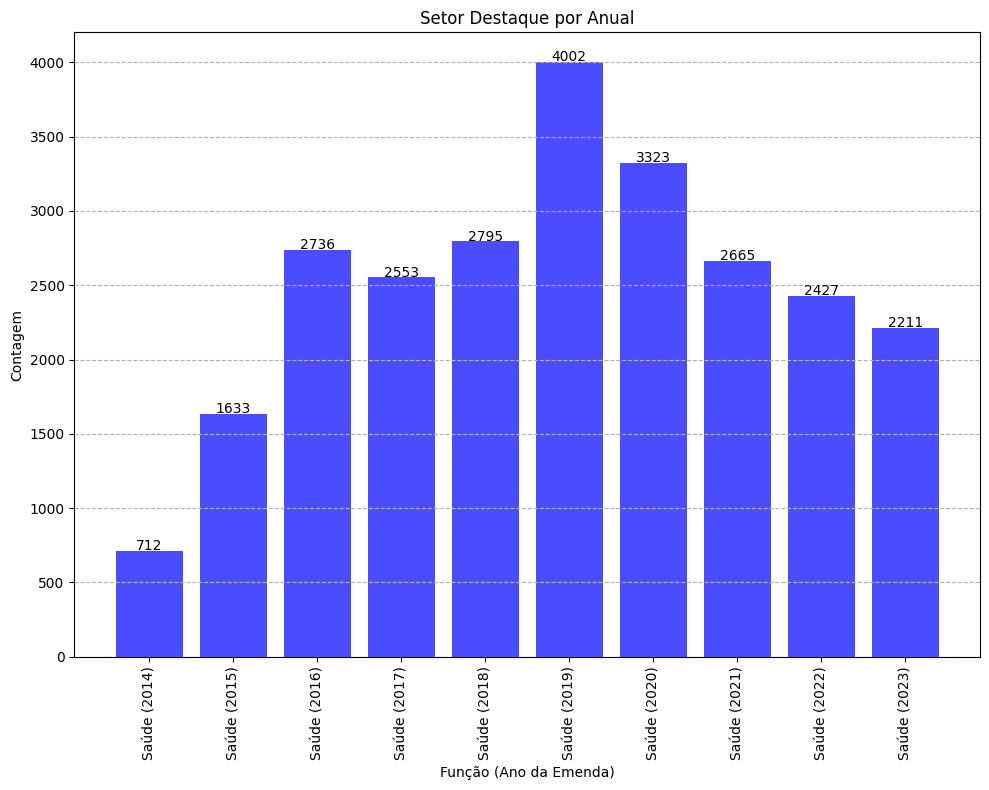

In [65]:
# Qual setor, a cada ano, se destaca mais
setor_destaque = resultados_anual.groupby('Ano da Emenda')['Contagem'].idxmax()
filtro_setor_destaque = resultados_anual.loc[setor_destaque]

plt.figure(figsize=(10, 8))
plt.bar(range(len(filtro_setor_destaque['Nome Função'])), filtro_setor_destaque['Contagem'], align='center', alpha=0.7, color='b')
plt.xlabel('Função (Ano da Emenda)')
plt.ylabel('Contagem')
plt.title(f'Setor Destaque por Anual')

# Concatenando o nome da função com o ano da emenda para o eixo x
rotulos_eixo_x = [f"{funcao} ({ano})" for funcao, ano in zip(filtro_setor_destaque['Nome Função'], filtro_setor_destaque['Ano da Emenda'])]
plt.xticks(range(len(filtro_setor_destaque['Nome Função'])), rotulos_eixo_x, rotation=90, ha='center')

for i, v in enumerate(filtro_setor_destaque['Contagem']):
    plt.text(i, min(v + 5, plt.ylim()[1] - 20), str(v), ha='center')

plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig(f"{name_directory}/Setor_Destaque_Anual.png")
plt.show()


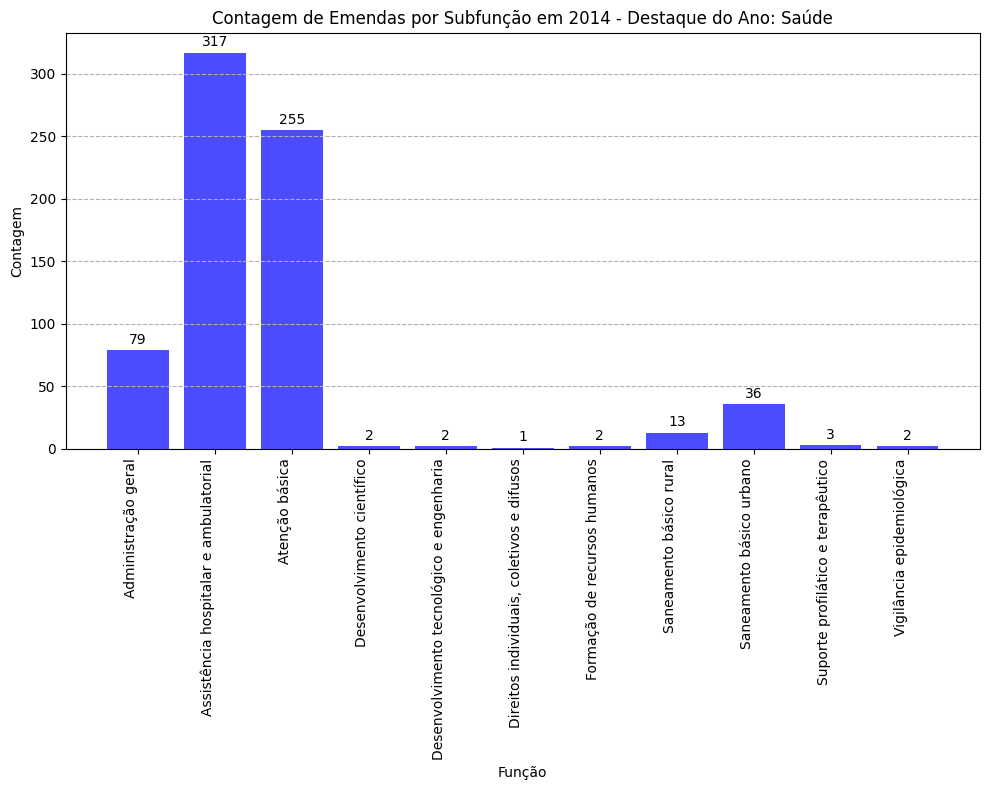

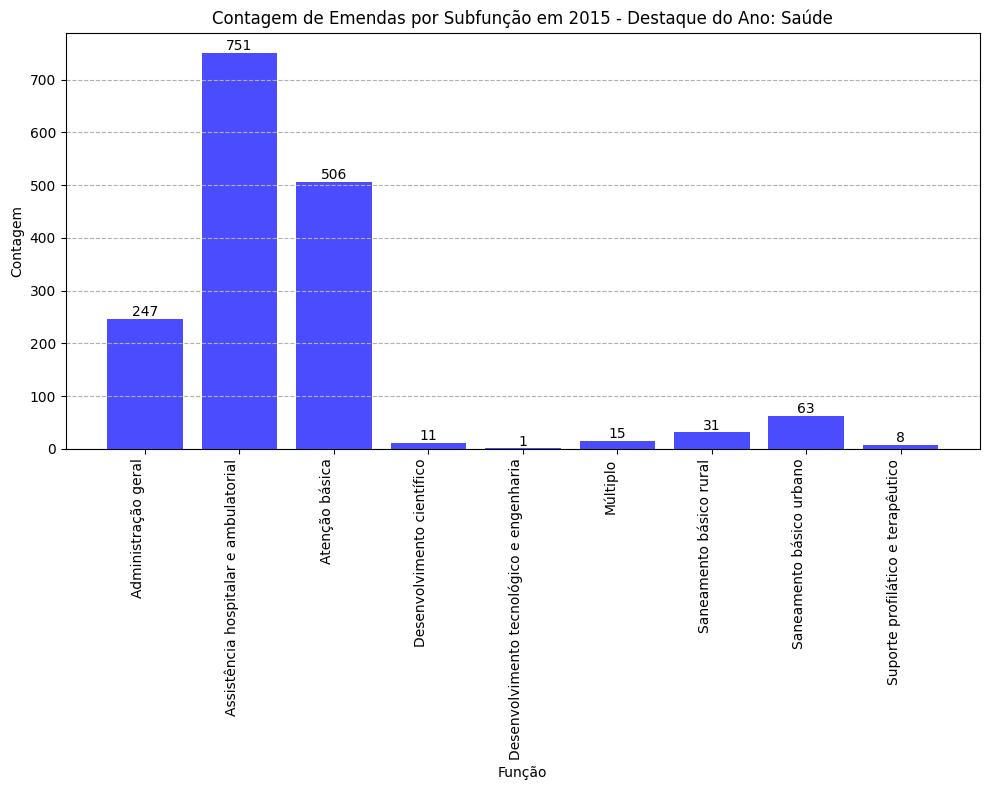

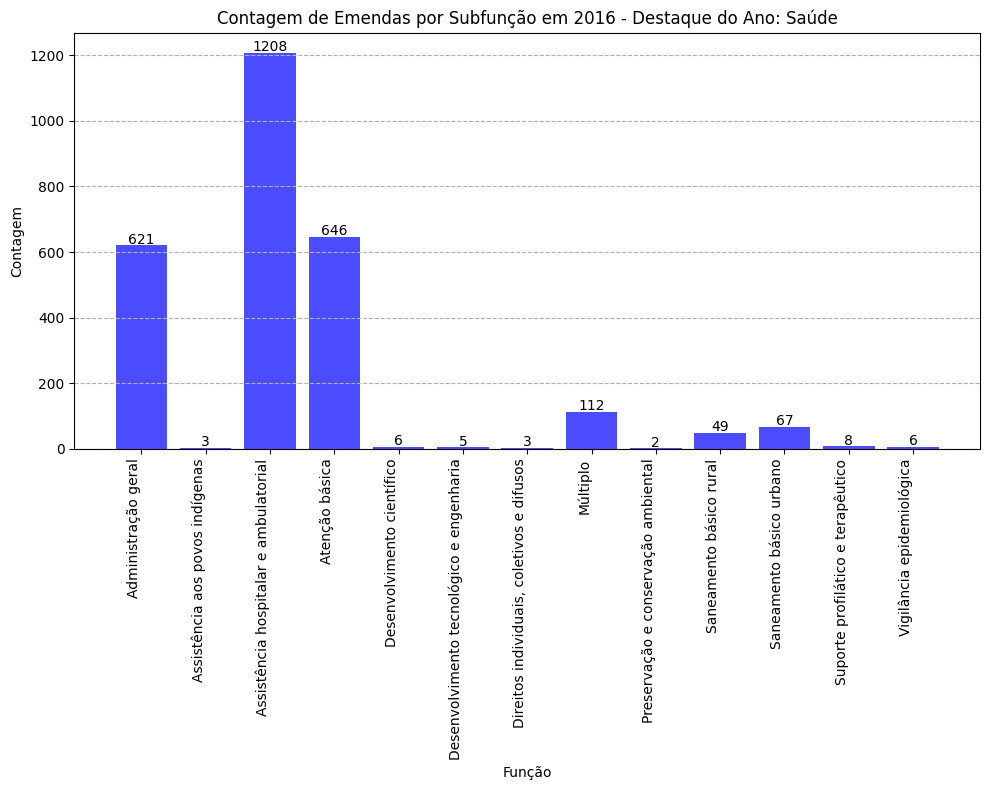

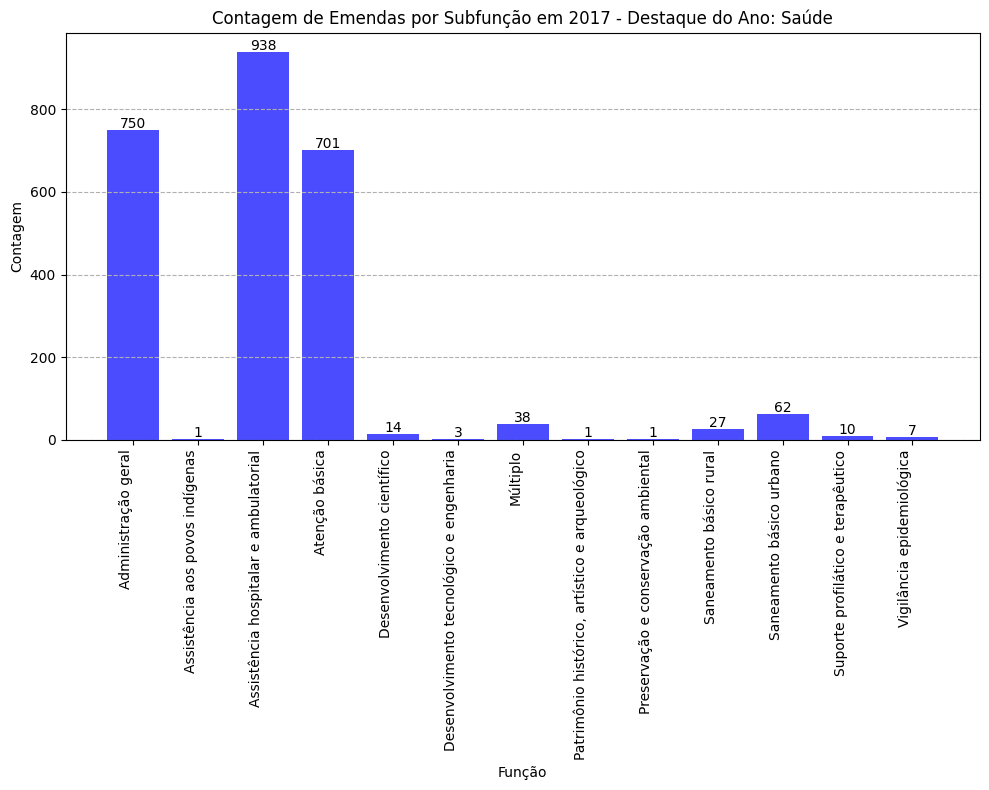

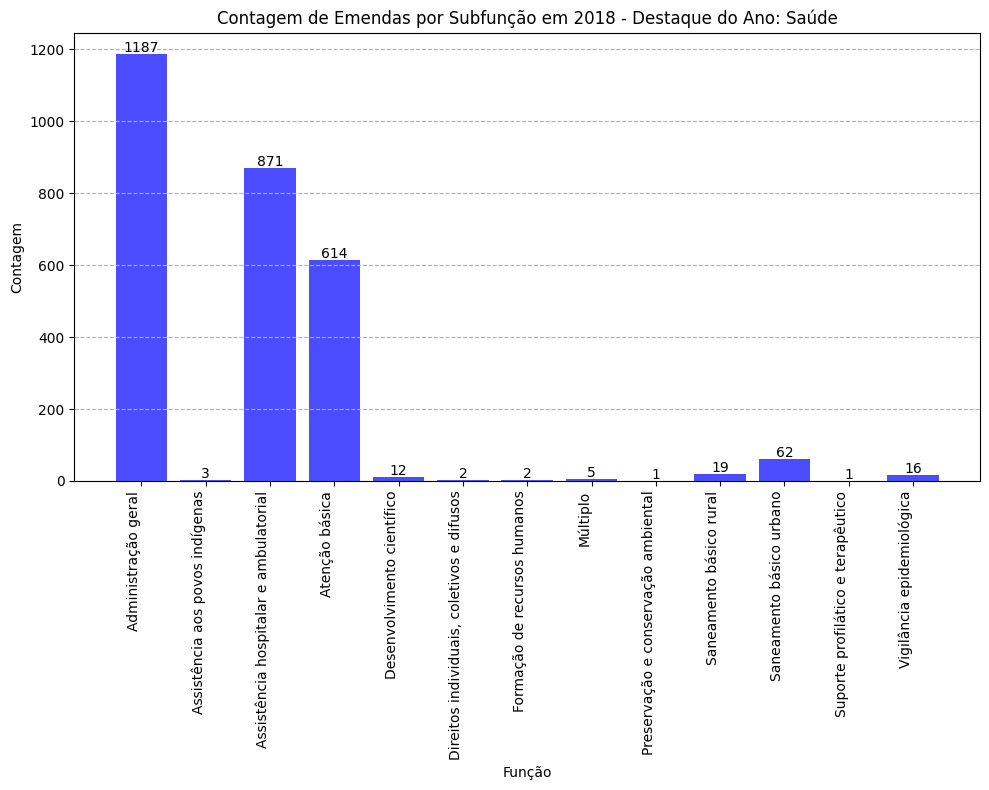

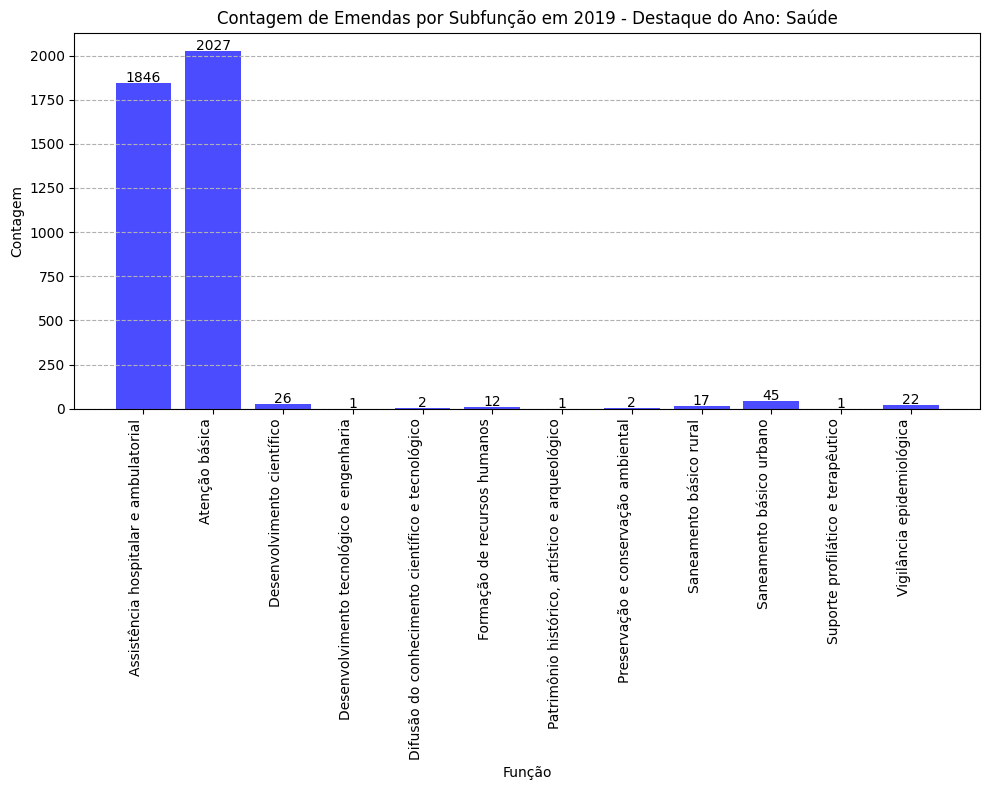

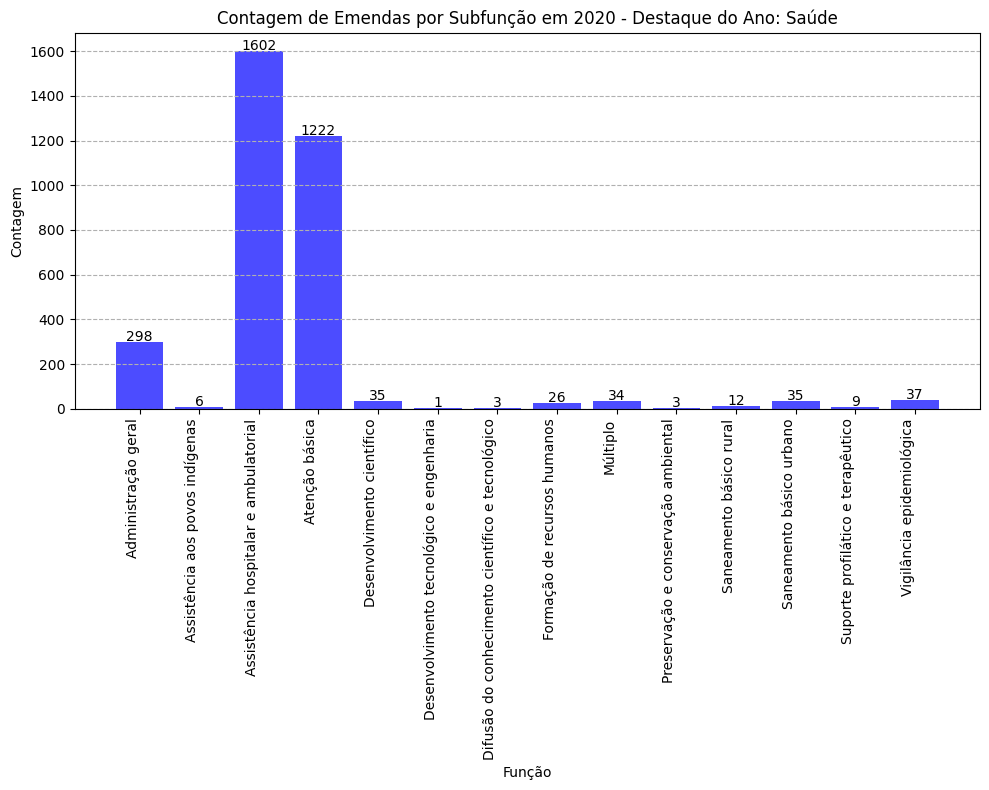

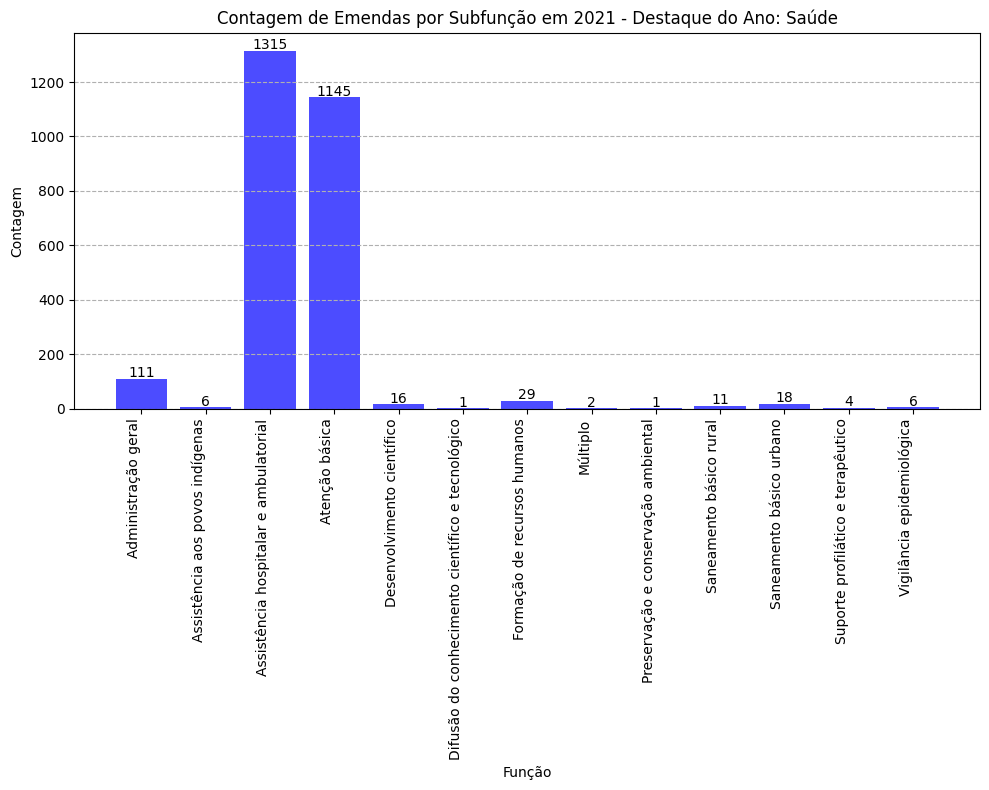

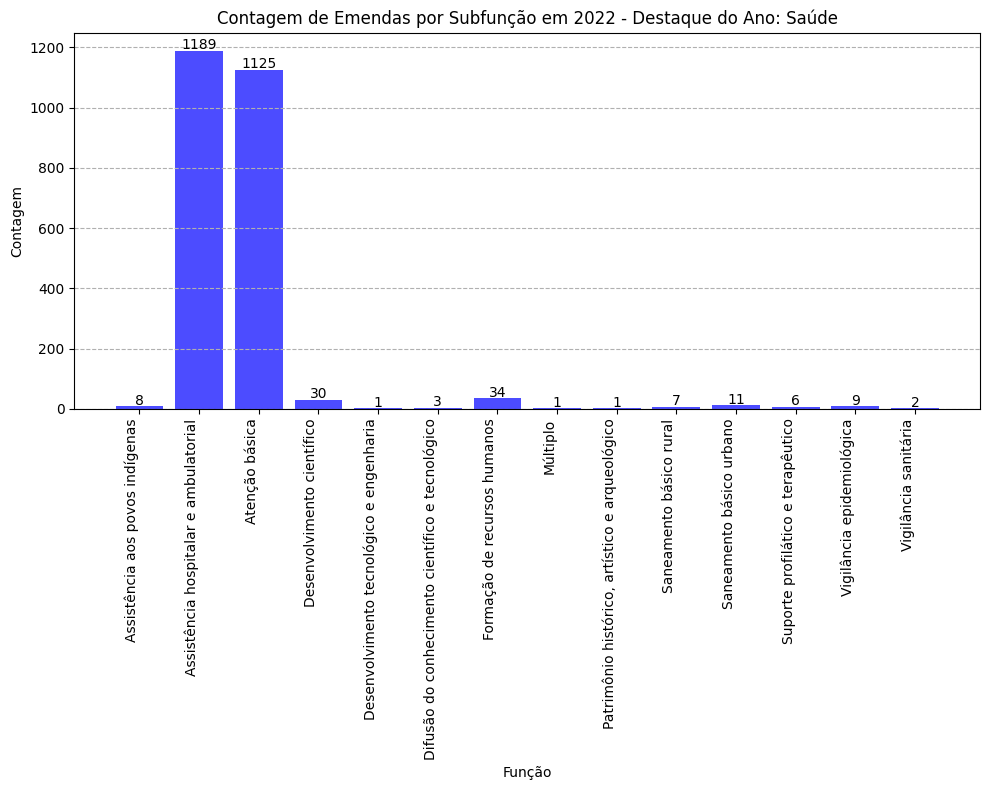

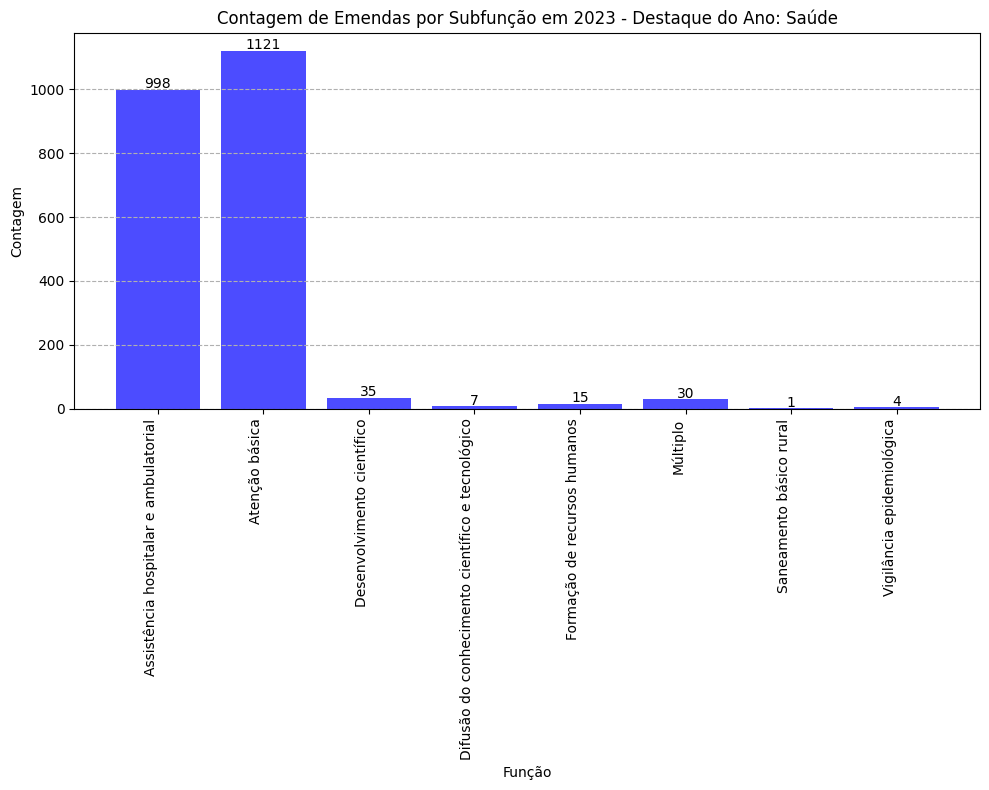

In [66]:
# A partir das funções destaques anuais, sinalize as subfunções e contagens
filtro_setores_frequentes = df_csv[(df_csv['Ano da Emenda'].isin(filtro_setor_destaque['Ano da Emenda'])) & (df_csv['Nome Função'].isin(filtro_setor_destaque['Nome Função']))]
contagem_subfuncao_anual = filtro_setores_frequentes.groupby(['Ano da Emenda', 'Nome Função', 'Nome Subfunção'])['Nome Subfunção'].count().reset_index(name='Contagem')

for ano in list(contagem_subfuncao_anual['Ano da Emenda'].unique()):
    contagem_subfuncao_anual_aux = contagem_subfuncao_anual[contagem_subfuncao_anual['Ano da Emenda'] == ano]
    plt.figure(figsize=(10, 8))
    plt.bar(range(len(contagem_subfuncao_anual_aux['Nome Subfunção'])), contagem_subfuncao_anual_aux['Contagem'], align='center', alpha=0.7, color='b')
    plt.xlabel('Função')
    plt.ylabel('Contagem')
    destaque = contagem_subfuncao_anual[contagem_subfuncao_anual['Ano da Emenda'] == ano]['Nome Função'].iloc[0]
    plt.title(f'Contagem de Emendas por Subfunção em {ano} - Destaque do Ano: {destaque}')
    plt.xticks(range(len(contagem_subfuncao_anual_aux['Nome Subfunção'])), contagem_subfuncao_anual_aux['Nome Subfunção'], rotation=90, ha='right')

    # Adiciona rótulos nas barras
    for i, v in enumerate(contagem_subfuncao_anual_aux['Contagem']):
        plt.text(i, v + 5, str(v), ha='center')

    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.tight_layout()
    plt.savefig(f"{name_directory}/Subfunção_dos_Setores_Destacados_Anual_{ano}.png")
    plt.show()

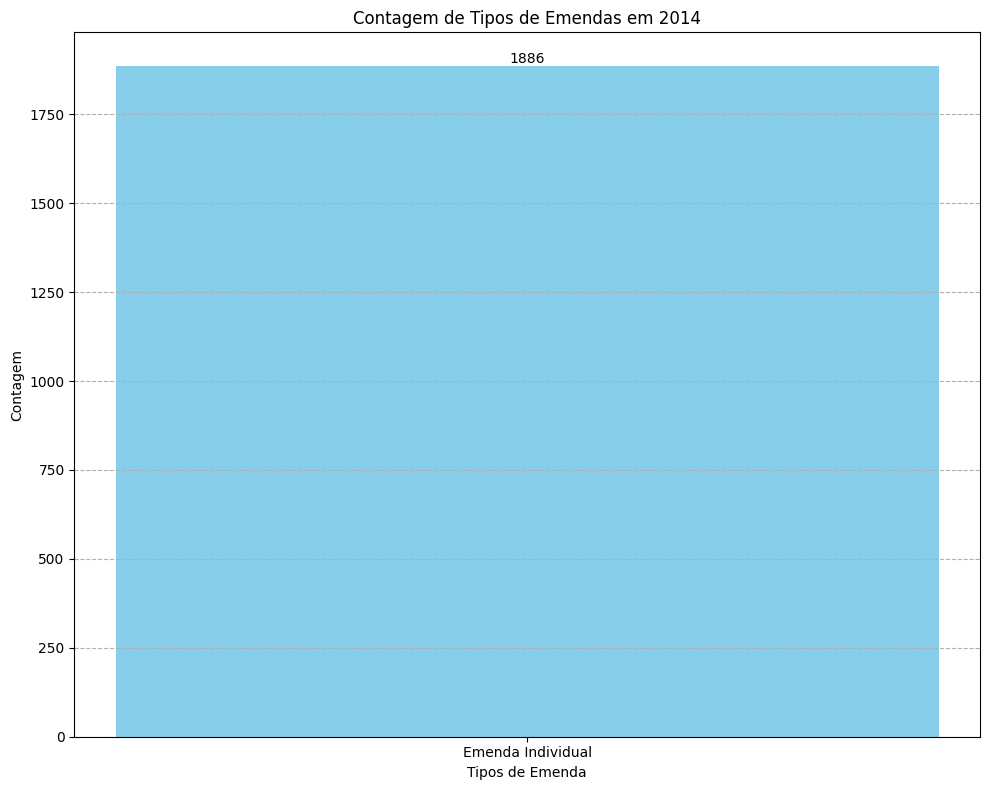

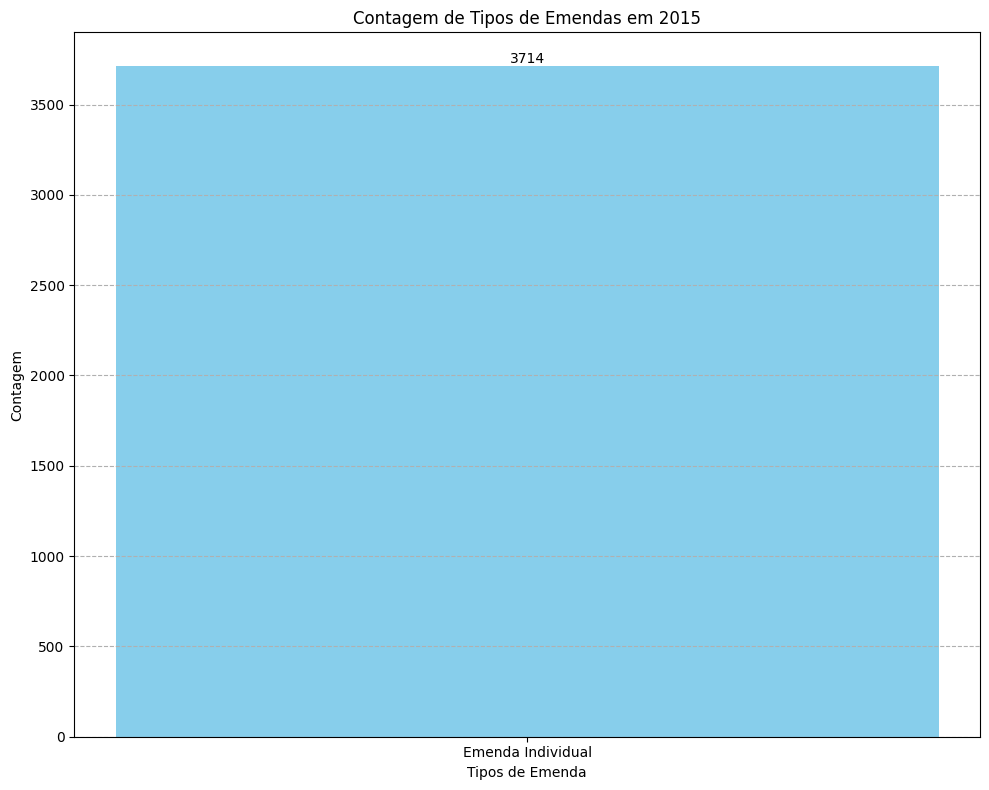

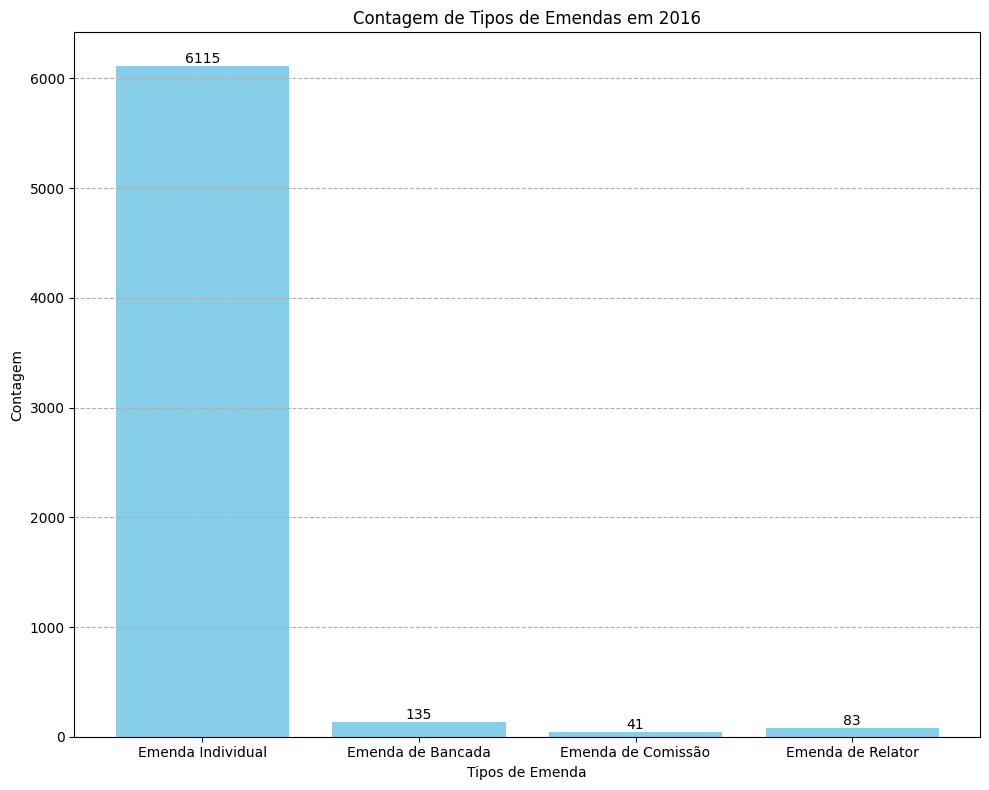

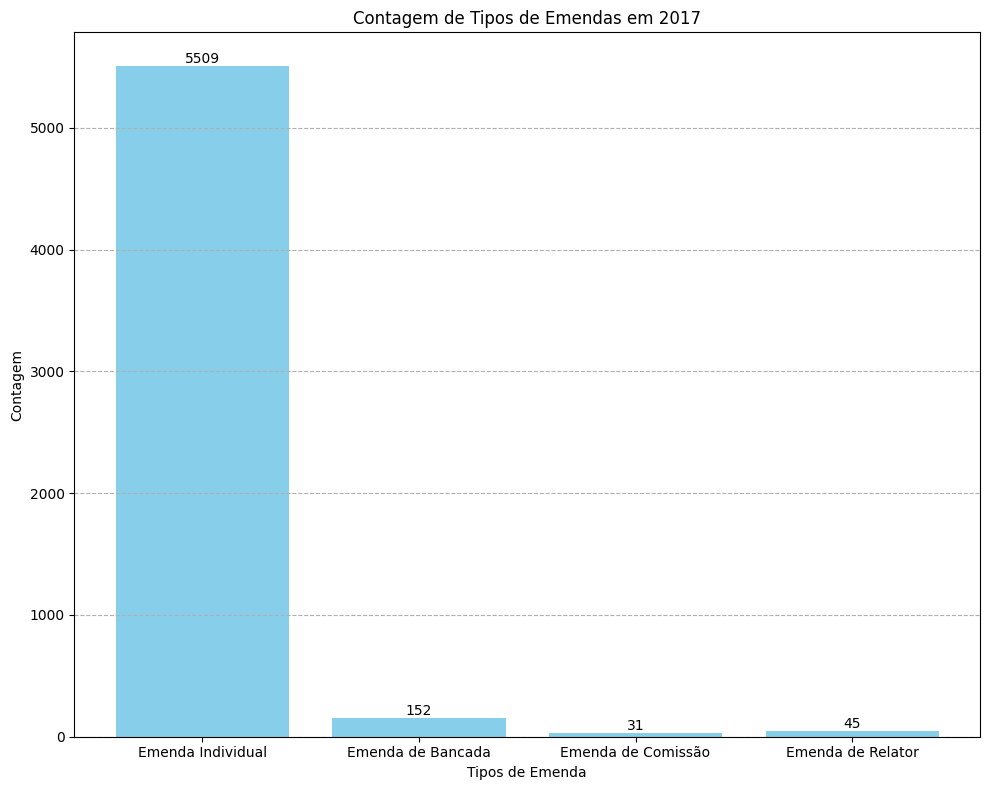

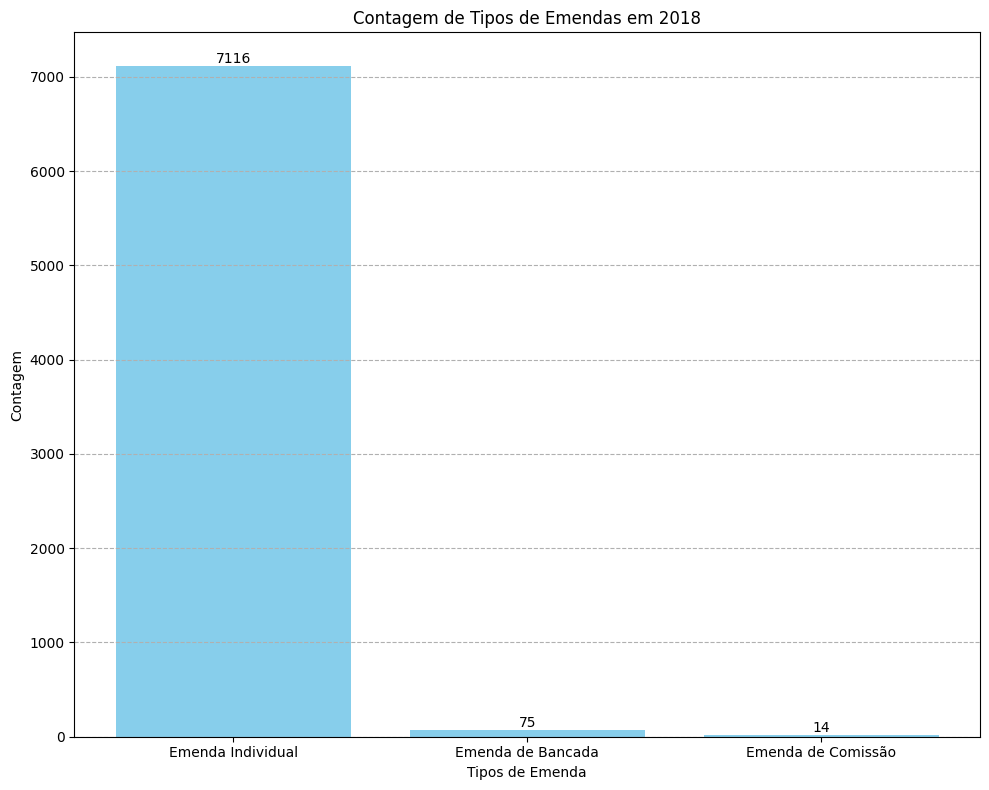

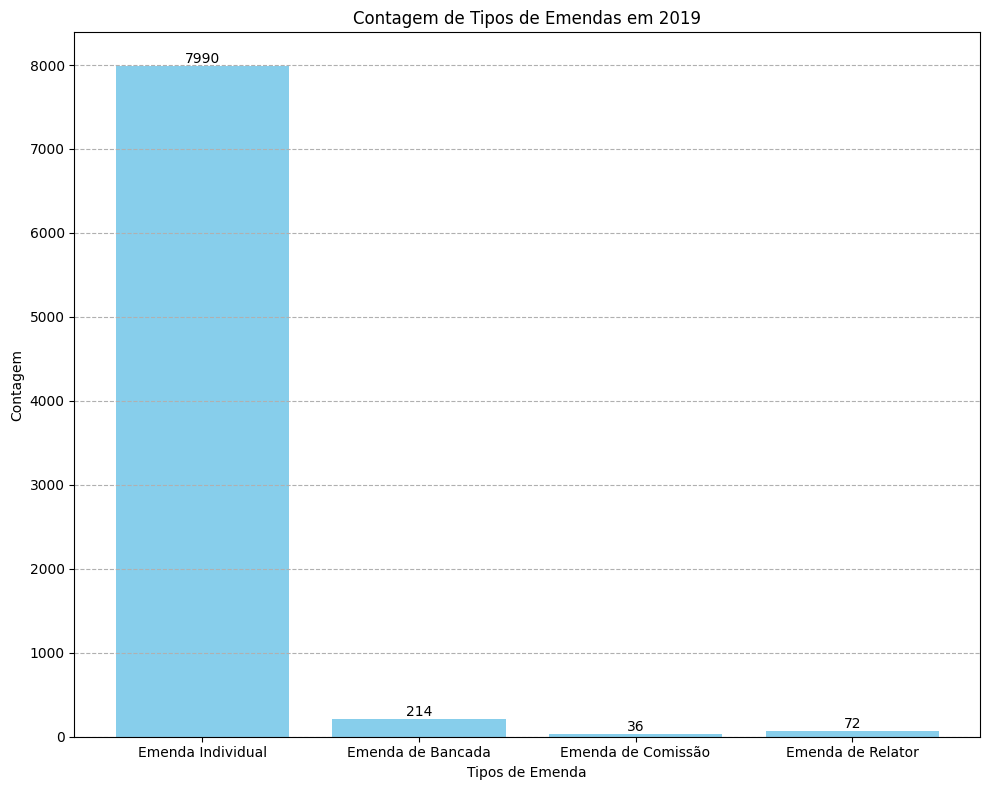

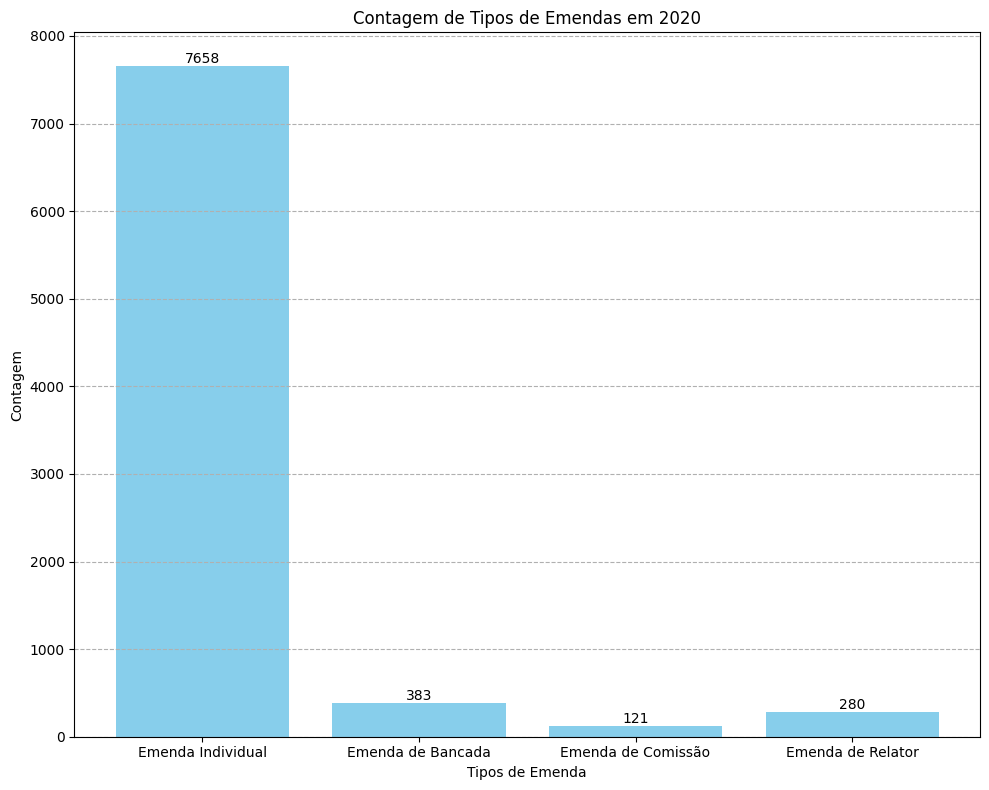

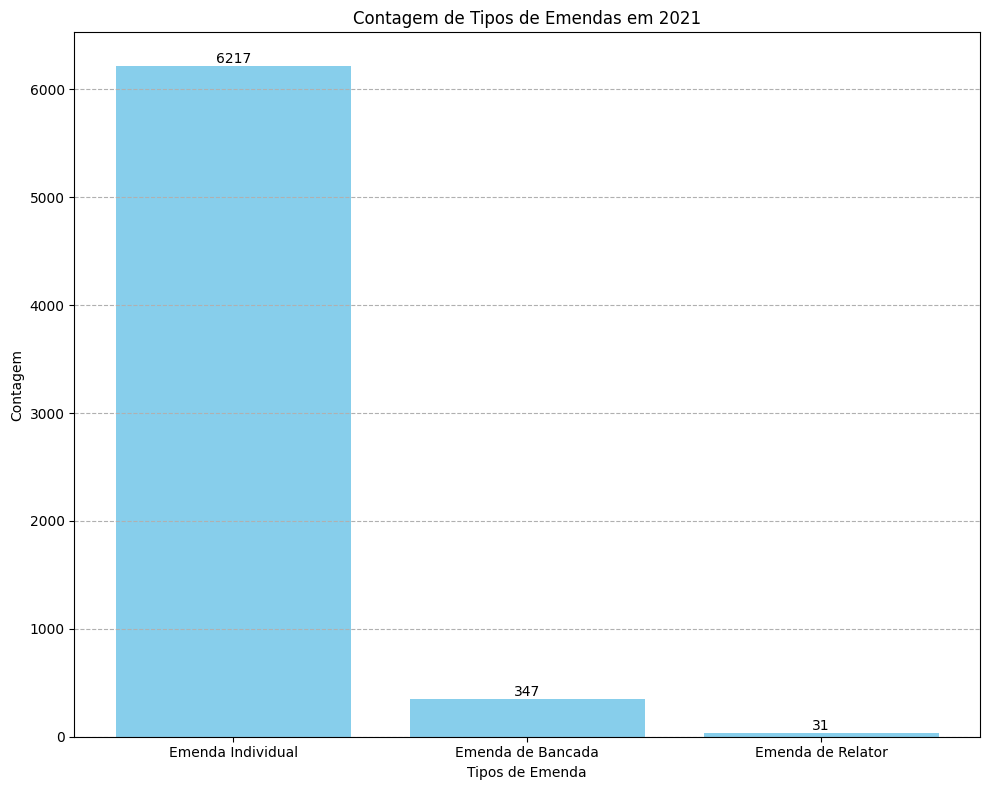

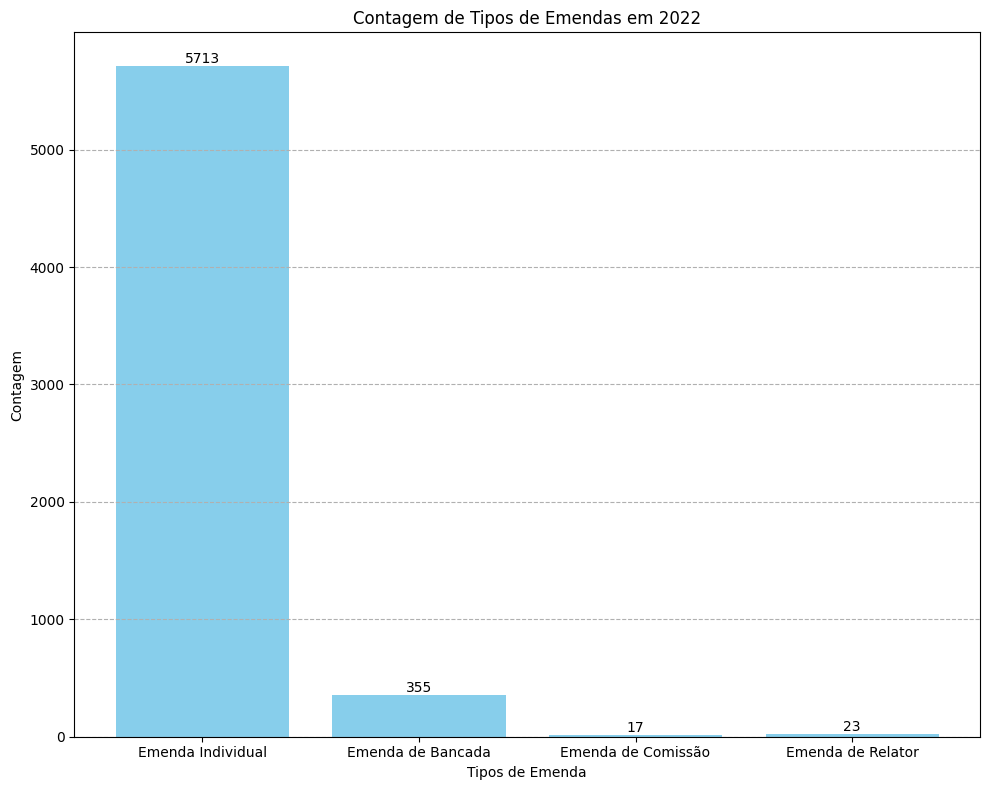

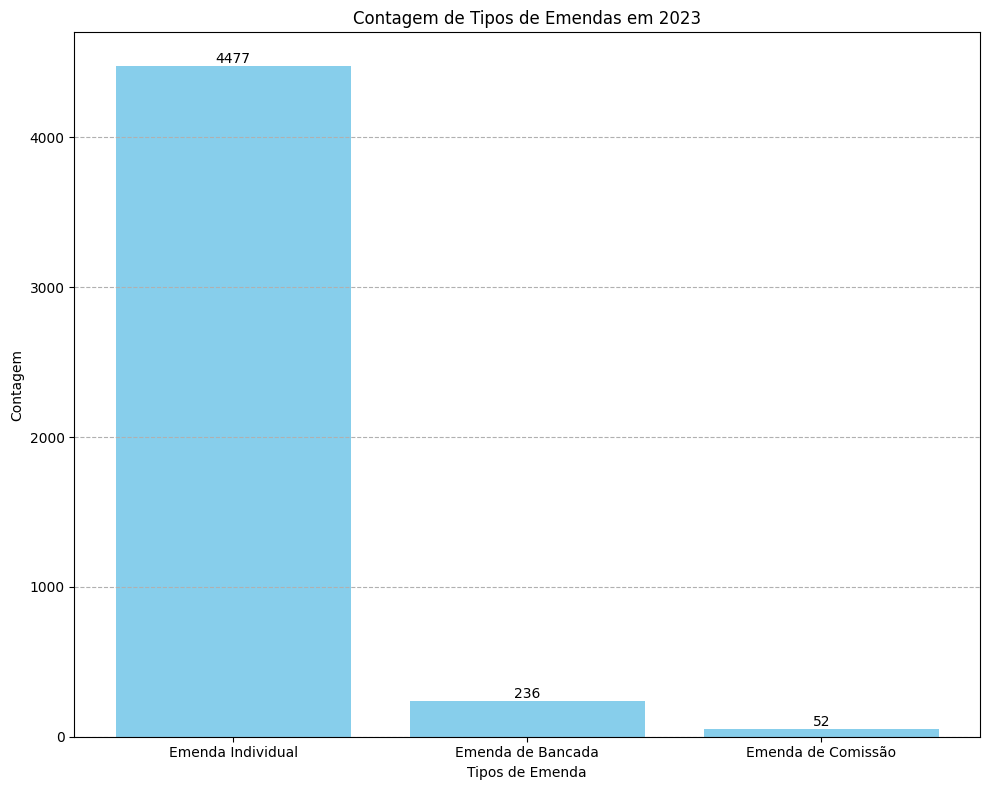

In [67]:
# Análise histórica dos tipos de emendas por ano
for ano in list(df_csv['Ano da Emenda'].unique()):
    # Contando a ocorrência de cada tipo de emenda
    df_csv_aux = df_csv.groupby(['Ano da Emenda', 'Tipo de Emenda']).size().reset_index(name='Contagem')
    df_csv_aux = df_csv_aux[df_csv_aux['Ano da Emenda'] == ano]

    plt.figure(figsize=(10, 8))
    plt.bar(df_csv_aux['Tipo de Emenda'], df_csv_aux['Contagem'], color='skyblue')

    for i, contagem in enumerate(df_csv_aux['Contagem']):
        plt.text(i, contagem + 0.1, str(contagem), ha='center', va='bottom')

    plt.xlabel('Tipos de Emenda')
    plt.ylabel('Contagem')
    plt.title(f'Contagem de Tipos de Emendas em {ano}')

    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.tight_layout()
    plt.savefig(f"{name_directory}/Tipos_Emendas_em_{ano}.png")
    plt.show()

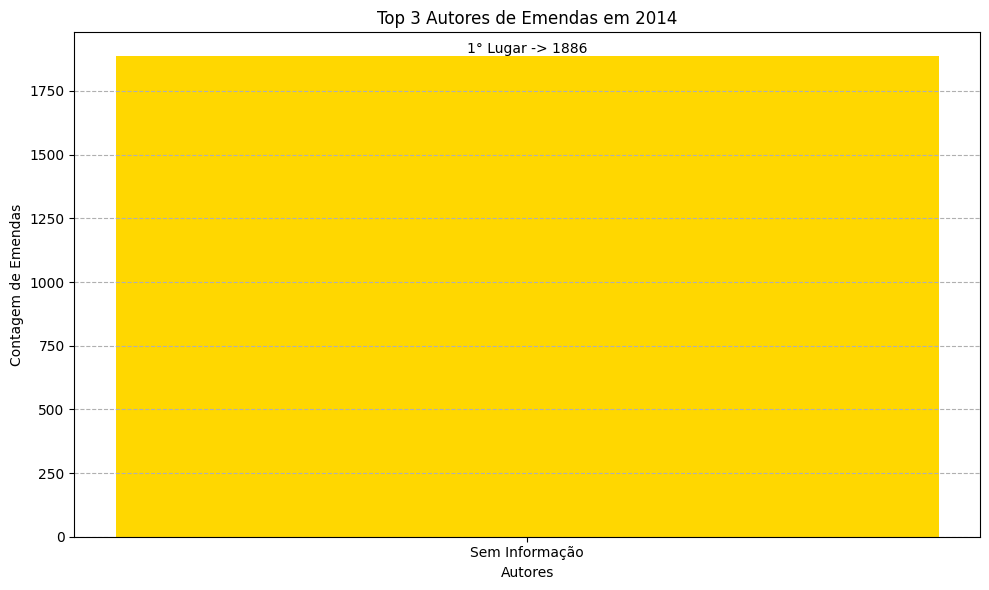

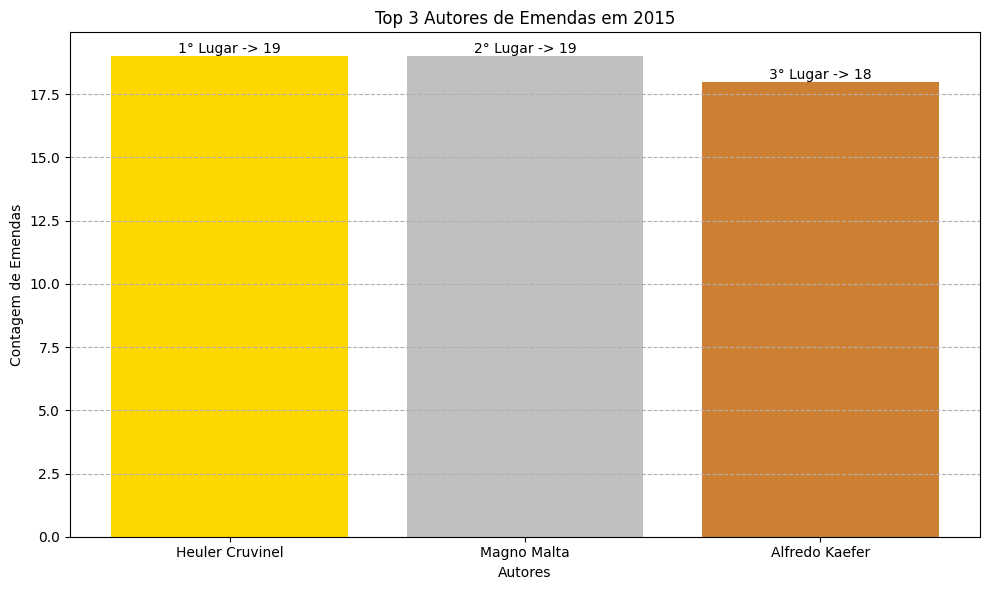

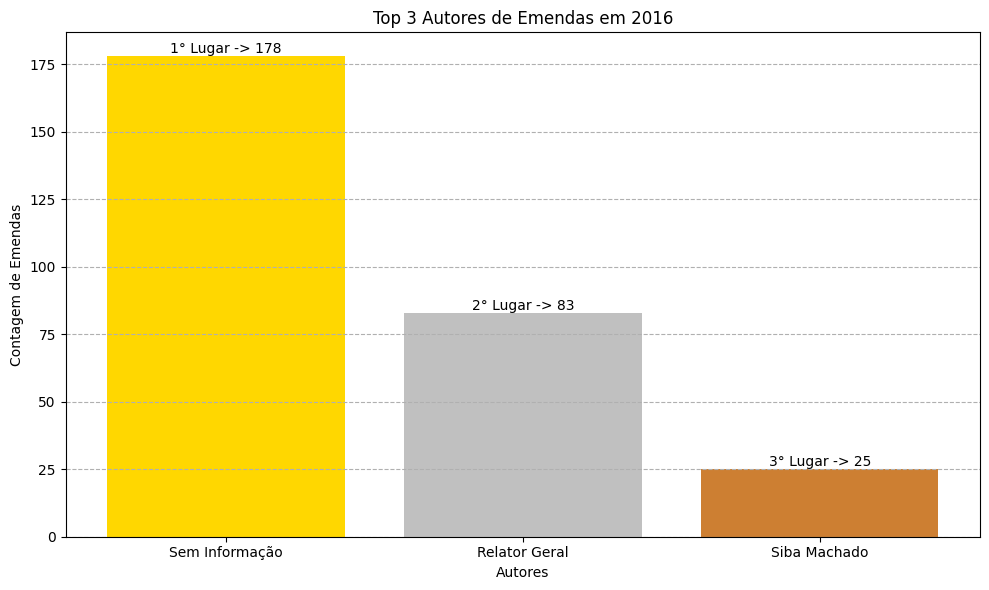

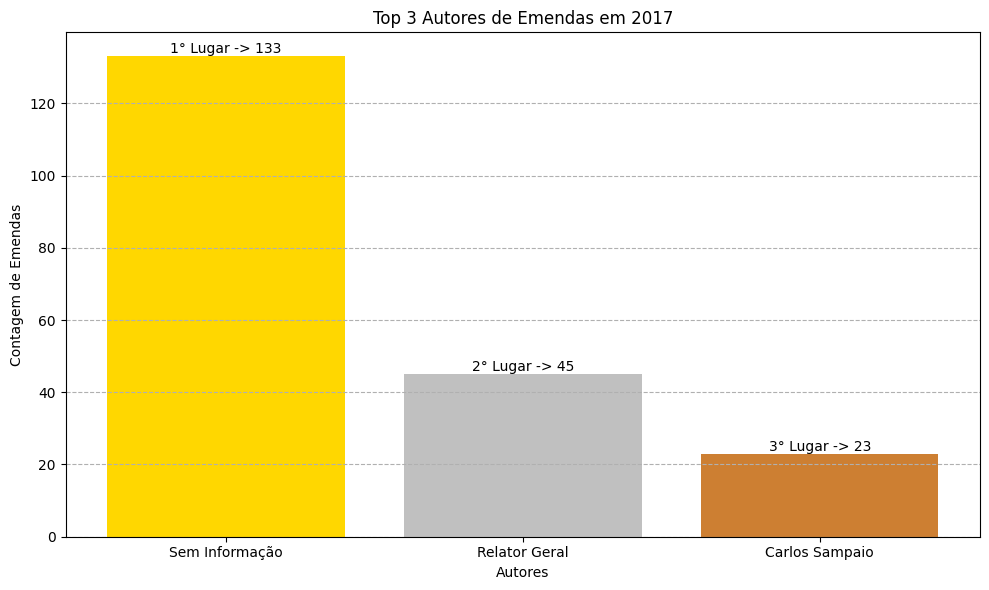

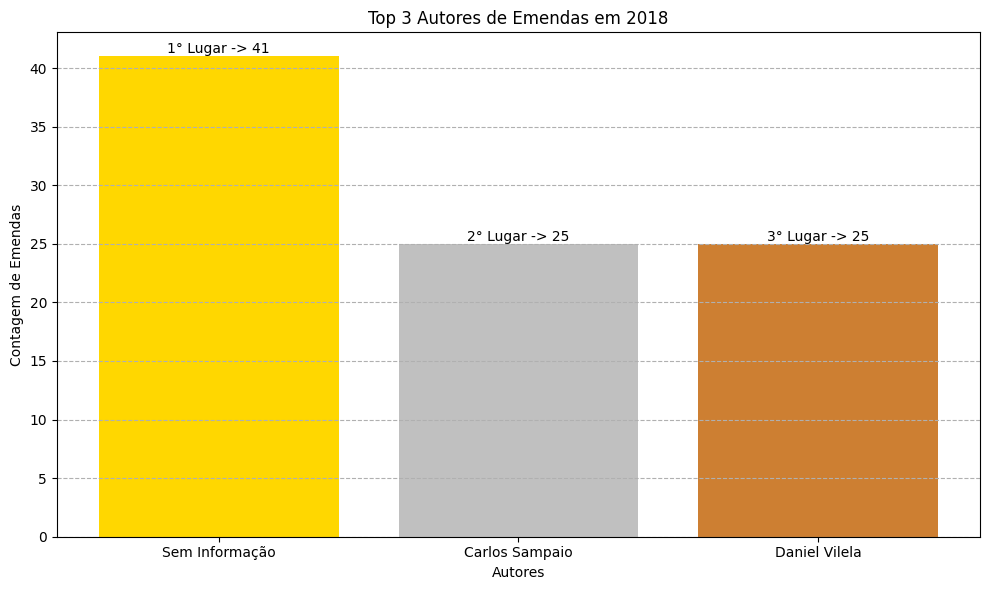

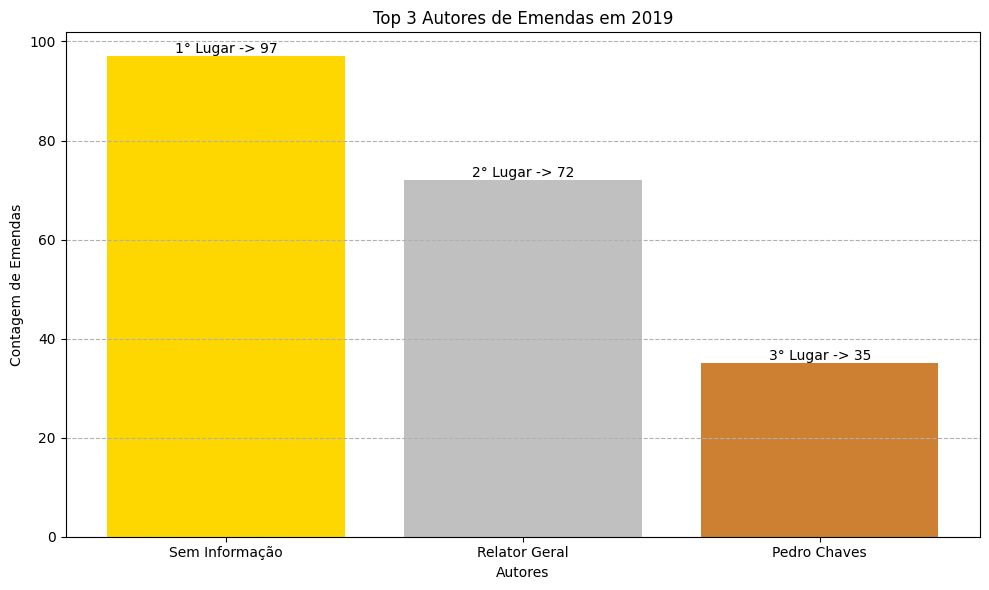

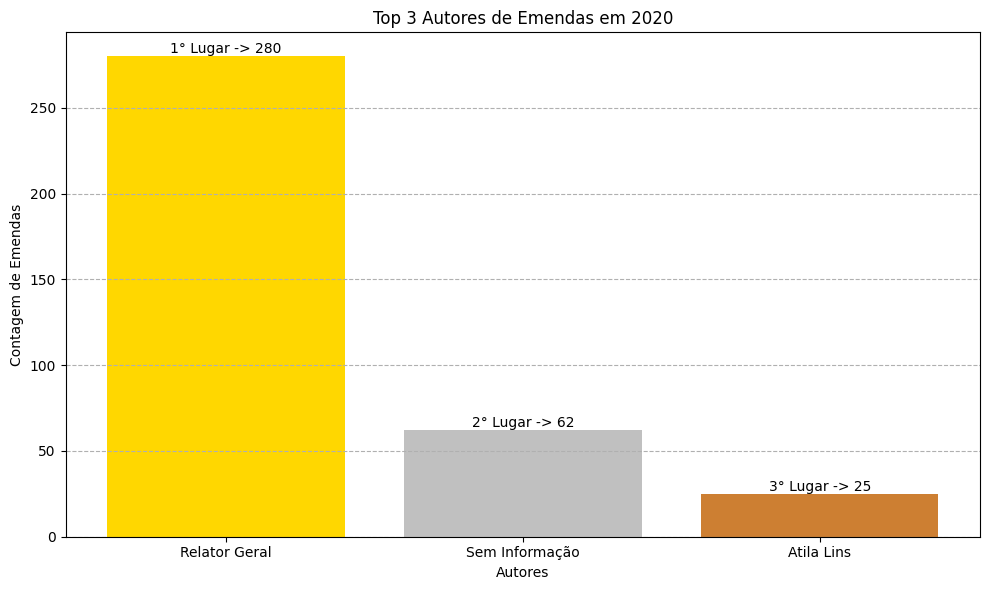

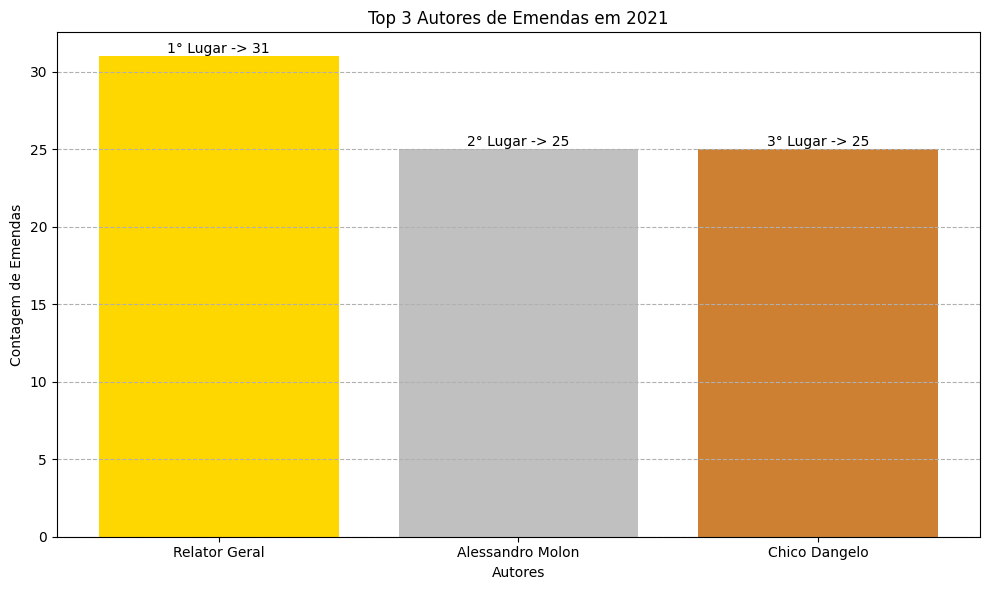

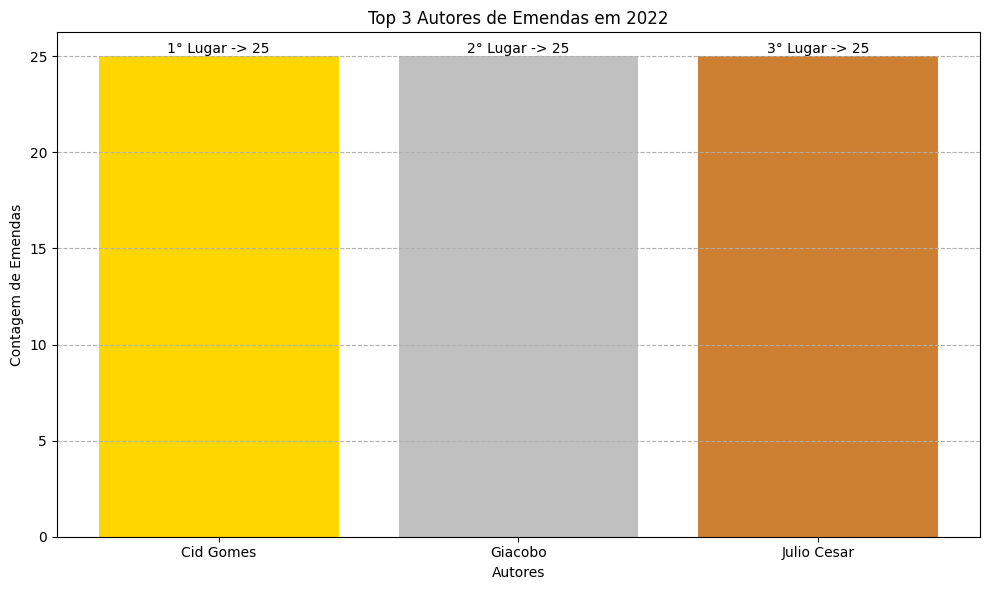

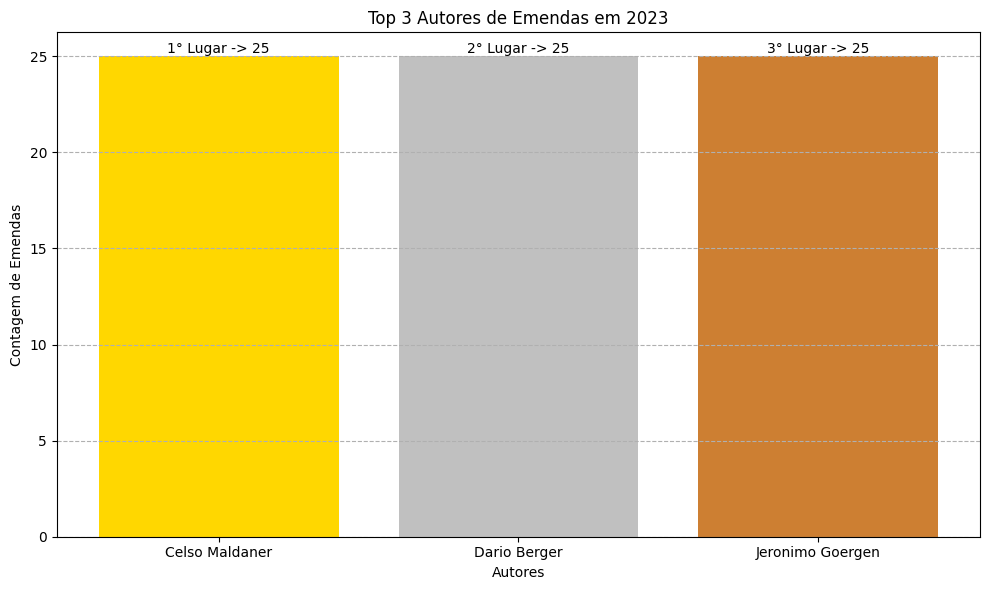

In [68]:
# Identificando por ano, o top 3 de autores de emenda, sinalizando os mais atuantes

grouped_df = df_csv.groupby(['Ano da Emenda', 'Nome do Autor da Emenda']).size().reset_index(name='Contagem')
sorted_df = grouped_df.sort_values(by=['Ano da Emenda', 'Contagem'], ascending=[True, False])

# Criando nova coluna chamada 'Rank' que representa o ranking de cada autor dentro de cada ano
sorted_df['Rank'] = sorted_df.groupby('Ano da Emenda').cumcount() + 1

# Filtrando para obter apenas os 3 principais autores de cada ano
top3_authors_per_year = sorted_df[sorted_df['Rank'] <= 3]

# Criando um gráfico de barras para visualizar o ranking dos autores
for year, data in top3_authors_per_year.groupby('Ano da Emenda'):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(data['Nome do Autor da Emenda'], data['Contagem'], color=['gold', 'silver', '#cd7f32'])
    
    # Adicione rótulos com a contagem e o ranking acima de cada barra
    for bar, count, rank in zip(bars, data['Contagem'], data['Rank']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{rank}° Lugar -> {int(count)}', ha='center', va='bottom')

    plt.title(f'Top 3 Autores de Emendas em {year}')
    plt.xlabel('Autores')
    plt.ylabel('Contagem de Emendas')

    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.tight_layout()
    plt.savefig(f"{name_directory}/Top3_Autor_Emendas_{year}.png")
    plt.show()

In [69]:
# Resumo Estatístico
resumo_estatistico = df_csv.describe()

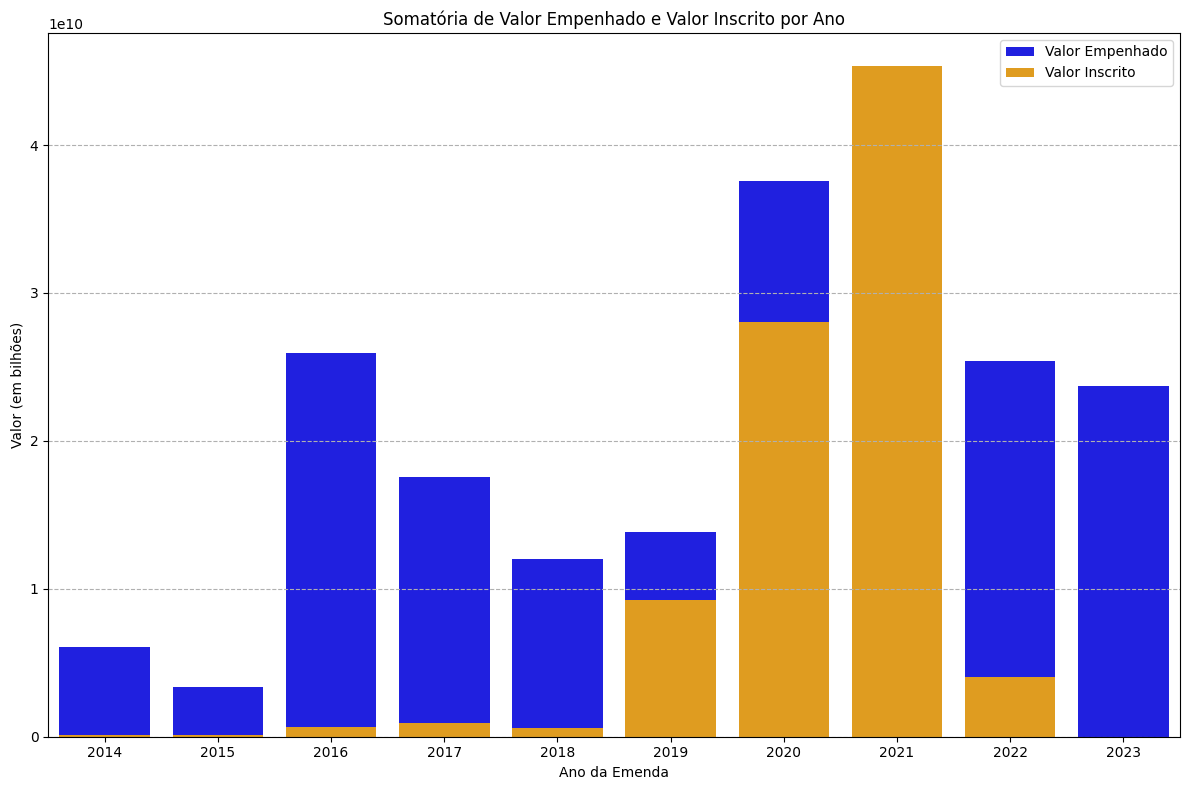

In [72]:
# Agrupe por ano e calcule a somatória de valor empenhado e inscrito
soma_valores = df_csv.groupby(pd.to_datetime(df_csv['Ano da Emenda'], format='%Y'))[['Valor Empenhado', 'Valor Restos A Pagar Inscritos']].sum()

soma_valores.index = soma_valores.index.map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").strftime("%Y"))

df_csv['Porcentagem Empenhado/Dívida'] = (soma_valores['Valor Empenhado'] / soma_valores['Valor Restos A Pagar Inscritos']) * 100

# Crie um gráfico de barras para a somatória de valor empenhado e inscrito
plt.figure(figsize=(12, 8))
sns.barplot(x=soma_valores.index, y=soma_valores['Valor Empenhado'], color='blue', label='Valor Empenhado')
sns.barplot(x=soma_valores.index, y=soma_valores['Valor Restos A Pagar Inscritos'], color='orange', label='Valor Inscrito')

plt.xlabel('Ano da Emenda')
plt.ylabel('Valor (em bilhões)')
plt.title('Somatória de Valor Empenhado e Valor Inscrito por Ano')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig(f"{name_directory}/Soma_Valor_Empenhado_e_Valor_Incristo_por_Ano.png")
plt.show()